In [94]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.optimize import curve_fit

from typing import Literal, Union

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl

from qs_mps.utils import create_sequential_colors
from qs_mps.applications.Z2.utils import find_closest_value, weighted_average
from qs_mps.applications.Z2.relevant_observables import (
                                                         n_order_kink_mass_varying_g,
                                                         n_order_kink_mass_varying_R,
                                                         get_fit_params,  
                                                         string_width_chis,
                                                         string_width_varying_g,
                                                         string_width_varying_R,
                                                         entropy,
                                                         time_entropy,
                                                         time_ev_string_width_occupation,
                                                         static_potential_chis, 
                                                         fitting
                                                        )
# default parameters of the plot layout
plt.rcParams["text.usetex"] = True  # use latex
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.constrained_layout.use"] = True

font = {'family': 'serif', 'size': 12}
plt.rcParams.update({'font.family': font['family'], 'font.size': font['size']})

model = "Z2_dual"
bc = "pbc"
cx = None
cy = None
sector = "2_particle(s)_sector"
Ls = [30]
L = 30

# take the path and precision to save files
# if we want to save the tensors we save them locally because they occupy a lot of memory
path = "add_your_path_to_save_data"
path = "/Users/fradm/Desktop/vanilla_data"
path = "C:/Users/HP/Desktop/vanilla_data"
path = "C:/Users/HP/Desktop/projects/1_Z2"
path = "/Users/fradm/Desktop/projects/1_Z2"
path_figures = "add_you_path_to_save_figures"
path_figures = "/Users/fradm/Google Drive/My Drive/projects/1_Z2"
# path_figures = "D:/code/projects/1_Z2"

colors = ["yellowgreen", "darkcyan", "firebrick", "darkorchid"]
colors = ["#60A7F3","#9E76AB","#DC4563"]
colors = ["#4688CE","#916799","#DC4563"]
colors = ["#4688CE","#9B4DB7","#DC4563"]
# colors = ["#FC4778","#BB4BA2","#7A4ECB","#3952F5"]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Potential

In [37]:
def plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=1):
    gammas, gammas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    plt.plot(gs, -np.asarray(gammas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=-np.asarray(gammas)-np.asarray(gammas_err),y2=-np.asarray(gammas)+np.asarray(gammas_err), color=color, alpha=0.4)

def plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=0):
    sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    plt.plot(gs, np.asarray(sigmas), marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=np.asarray(sigmas)-np.asarray(sigmas_err),y2=np.asarray(sigmas)+np.asarray(sigmas_err), color=color, alpha=0.4)

def plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,color,fit=3,param=2):
    sigmas, sigmas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=0)
    deltas, deltas_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=param)
    obs = - np.asarray(deltas)*np.asarray(sigmas)
    obs_err = np.sqrt((np.asarray(deltas)*np.asarray(sigmas_err))**2 + (np.asarray(sigmas)*np.asarray(deltas_err))**2)
    plt.plot(gs, obs, marker='', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$l: {l}$")
    plt.fill_between(gs, y1=obs-obs_err,y2=obs+obs_err, color=color, alpha=0.4)


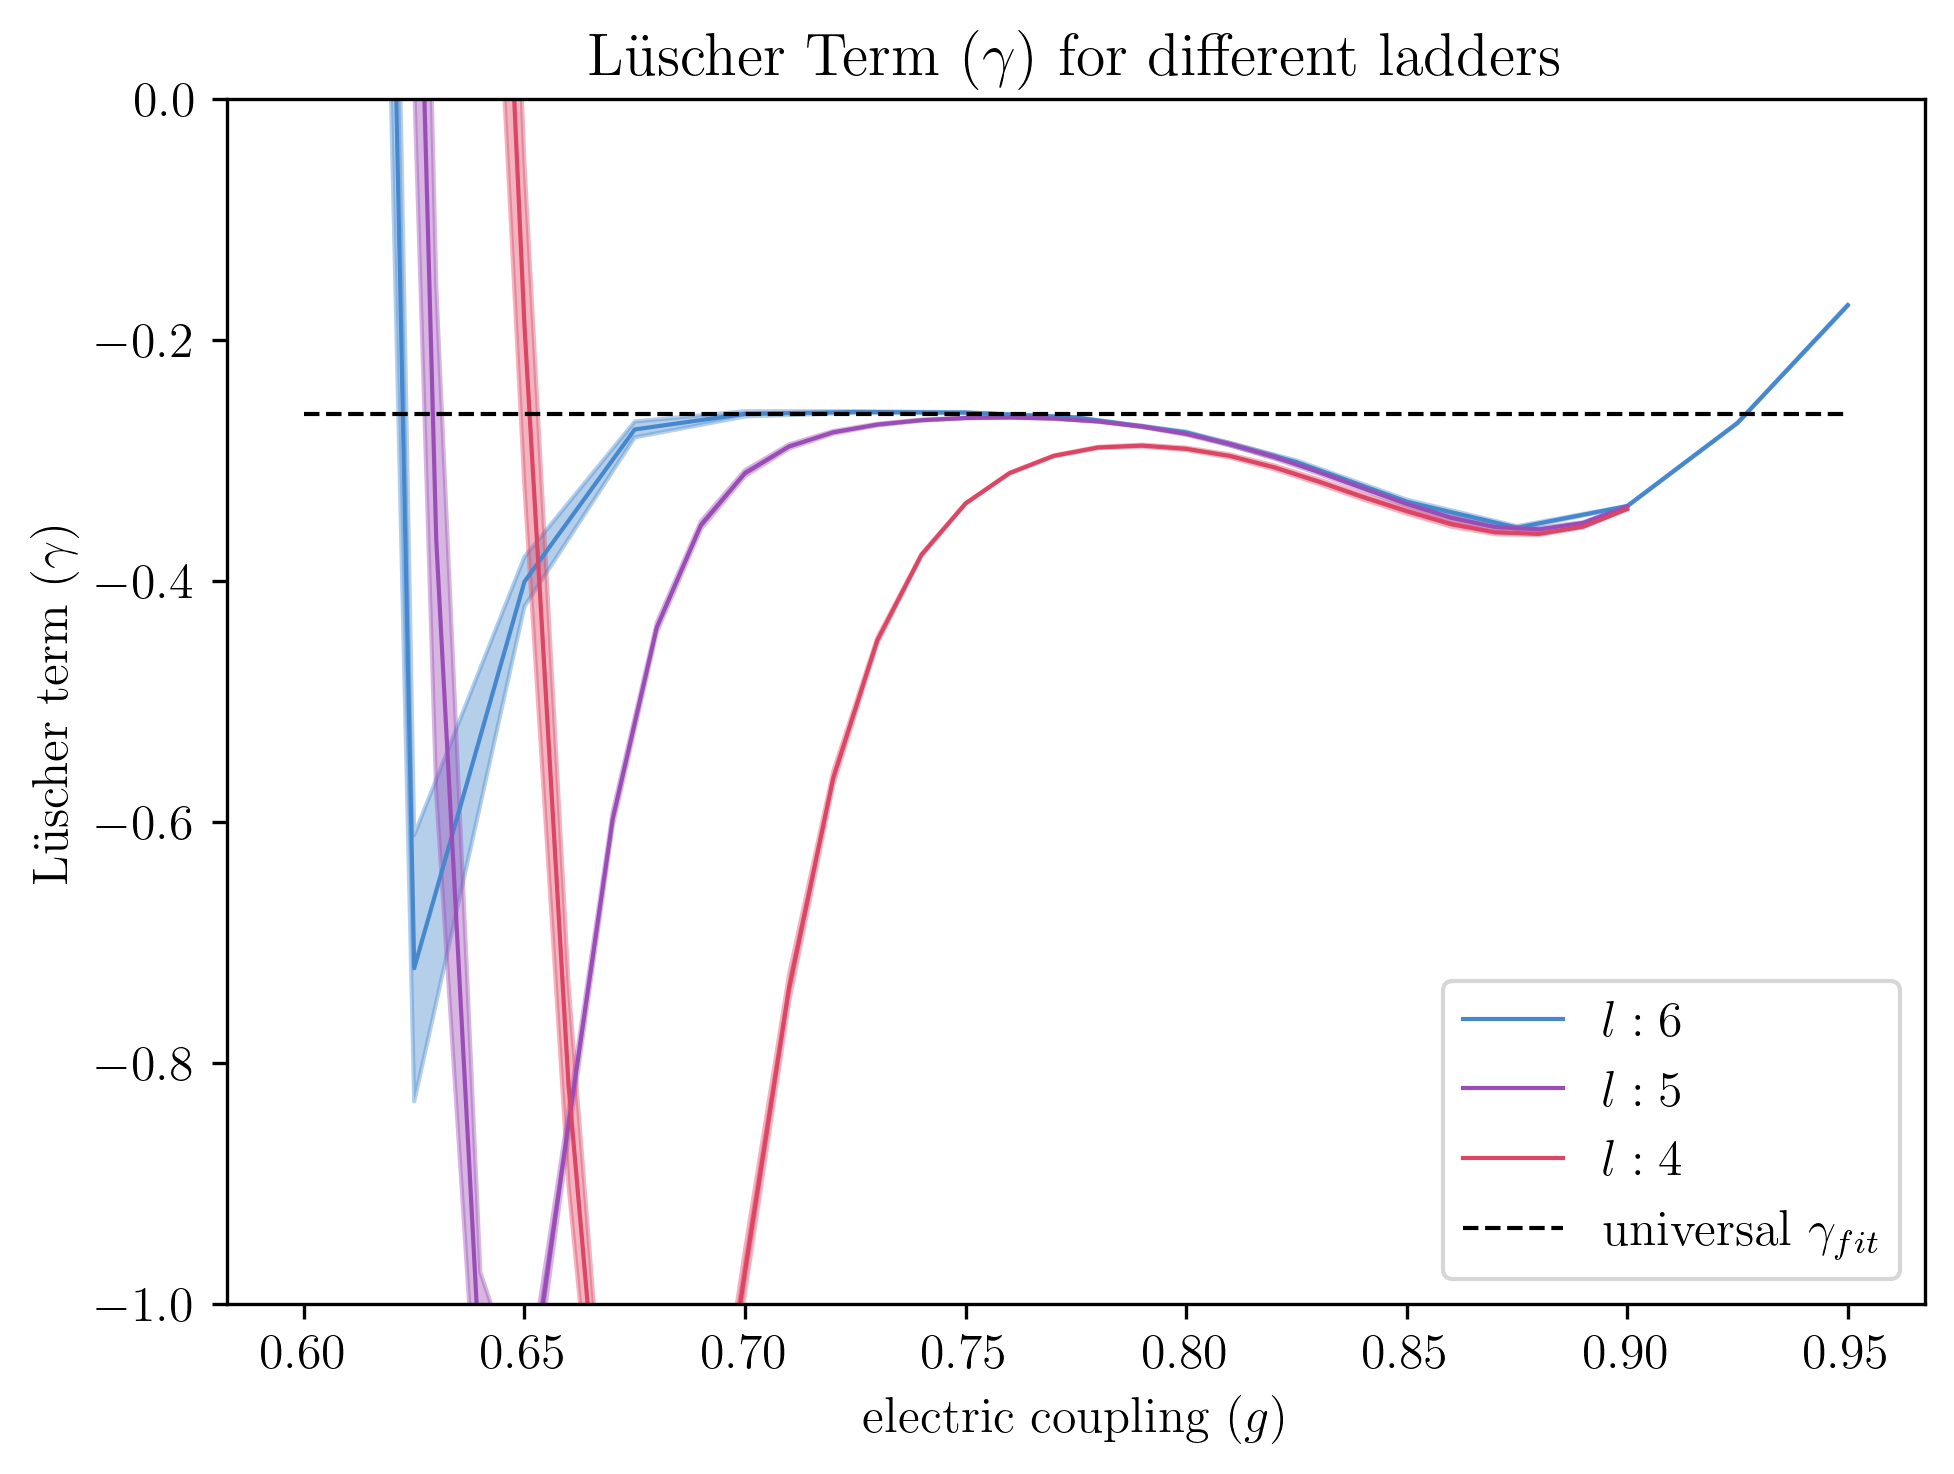

In [38]:
# h_i, h_f, npoints = 0.6, 0.8, 30
# gs = np.linspace(h_i,h_f,npoints)
# chis = [32,64,128]
# Rss = [10,12,14,16,18,20,22,24]
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_gamma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])



# plt.hlines(y=-np.pi/24, xmin=gs[0], xmax=gs[-1], linestyles="-.", colors='red', linestyle="--", linewidth=1, label="$\\gamma_{th}$, $d=3$")
plt.hlines(y=-2*np.pi/24, xmin=gs[0], xmax=0.95, linestyles="--", colors='black', linewidth=1, label="universal $\\gamma_{fit}$")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
# plt.ylim((-1,0))
plt.ylim((-1,0))
plt.title("Lüscher Term $(\\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("Lüscher term $(\\gamma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/luscher_term_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")


<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_34512/2601444693.py:34: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel("String tension $(\sigma)$")


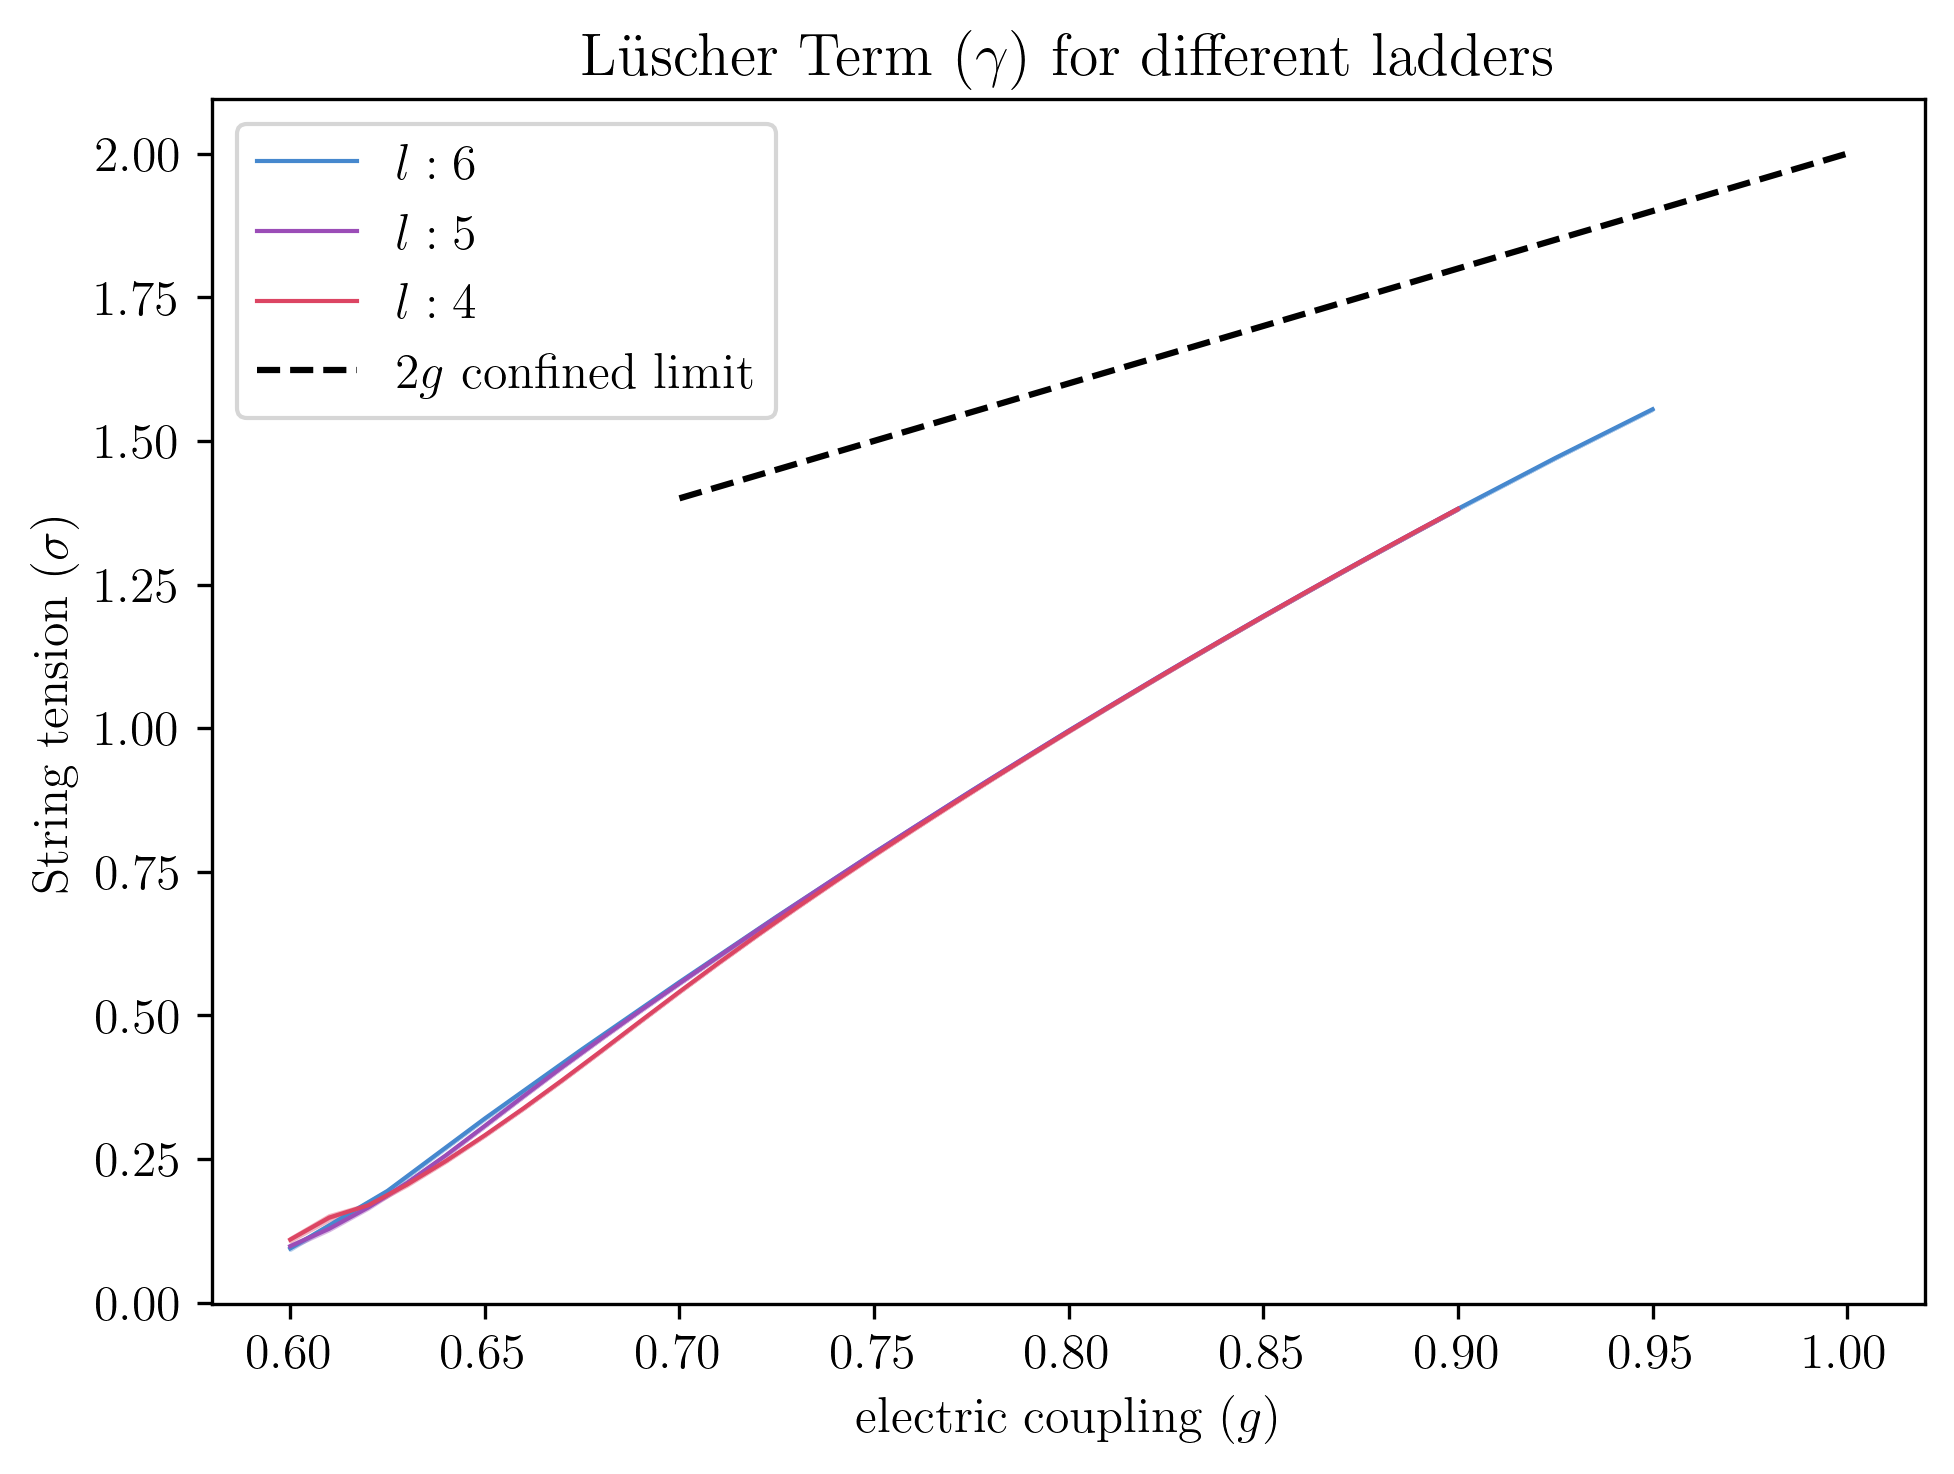

In [39]:
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_sigma(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])



x = np.linspace(0.7,1)
plt.plot(x,2*x, linestyle="--", color="black", label="$2g$ confined limit")
# plt.grid(True)
# plt.ylim((-0.4,-0.2))
plt.title("Lüscher Term $(\\gamma)$ for different ladders")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("String tension $(\sigma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/string_tension_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")

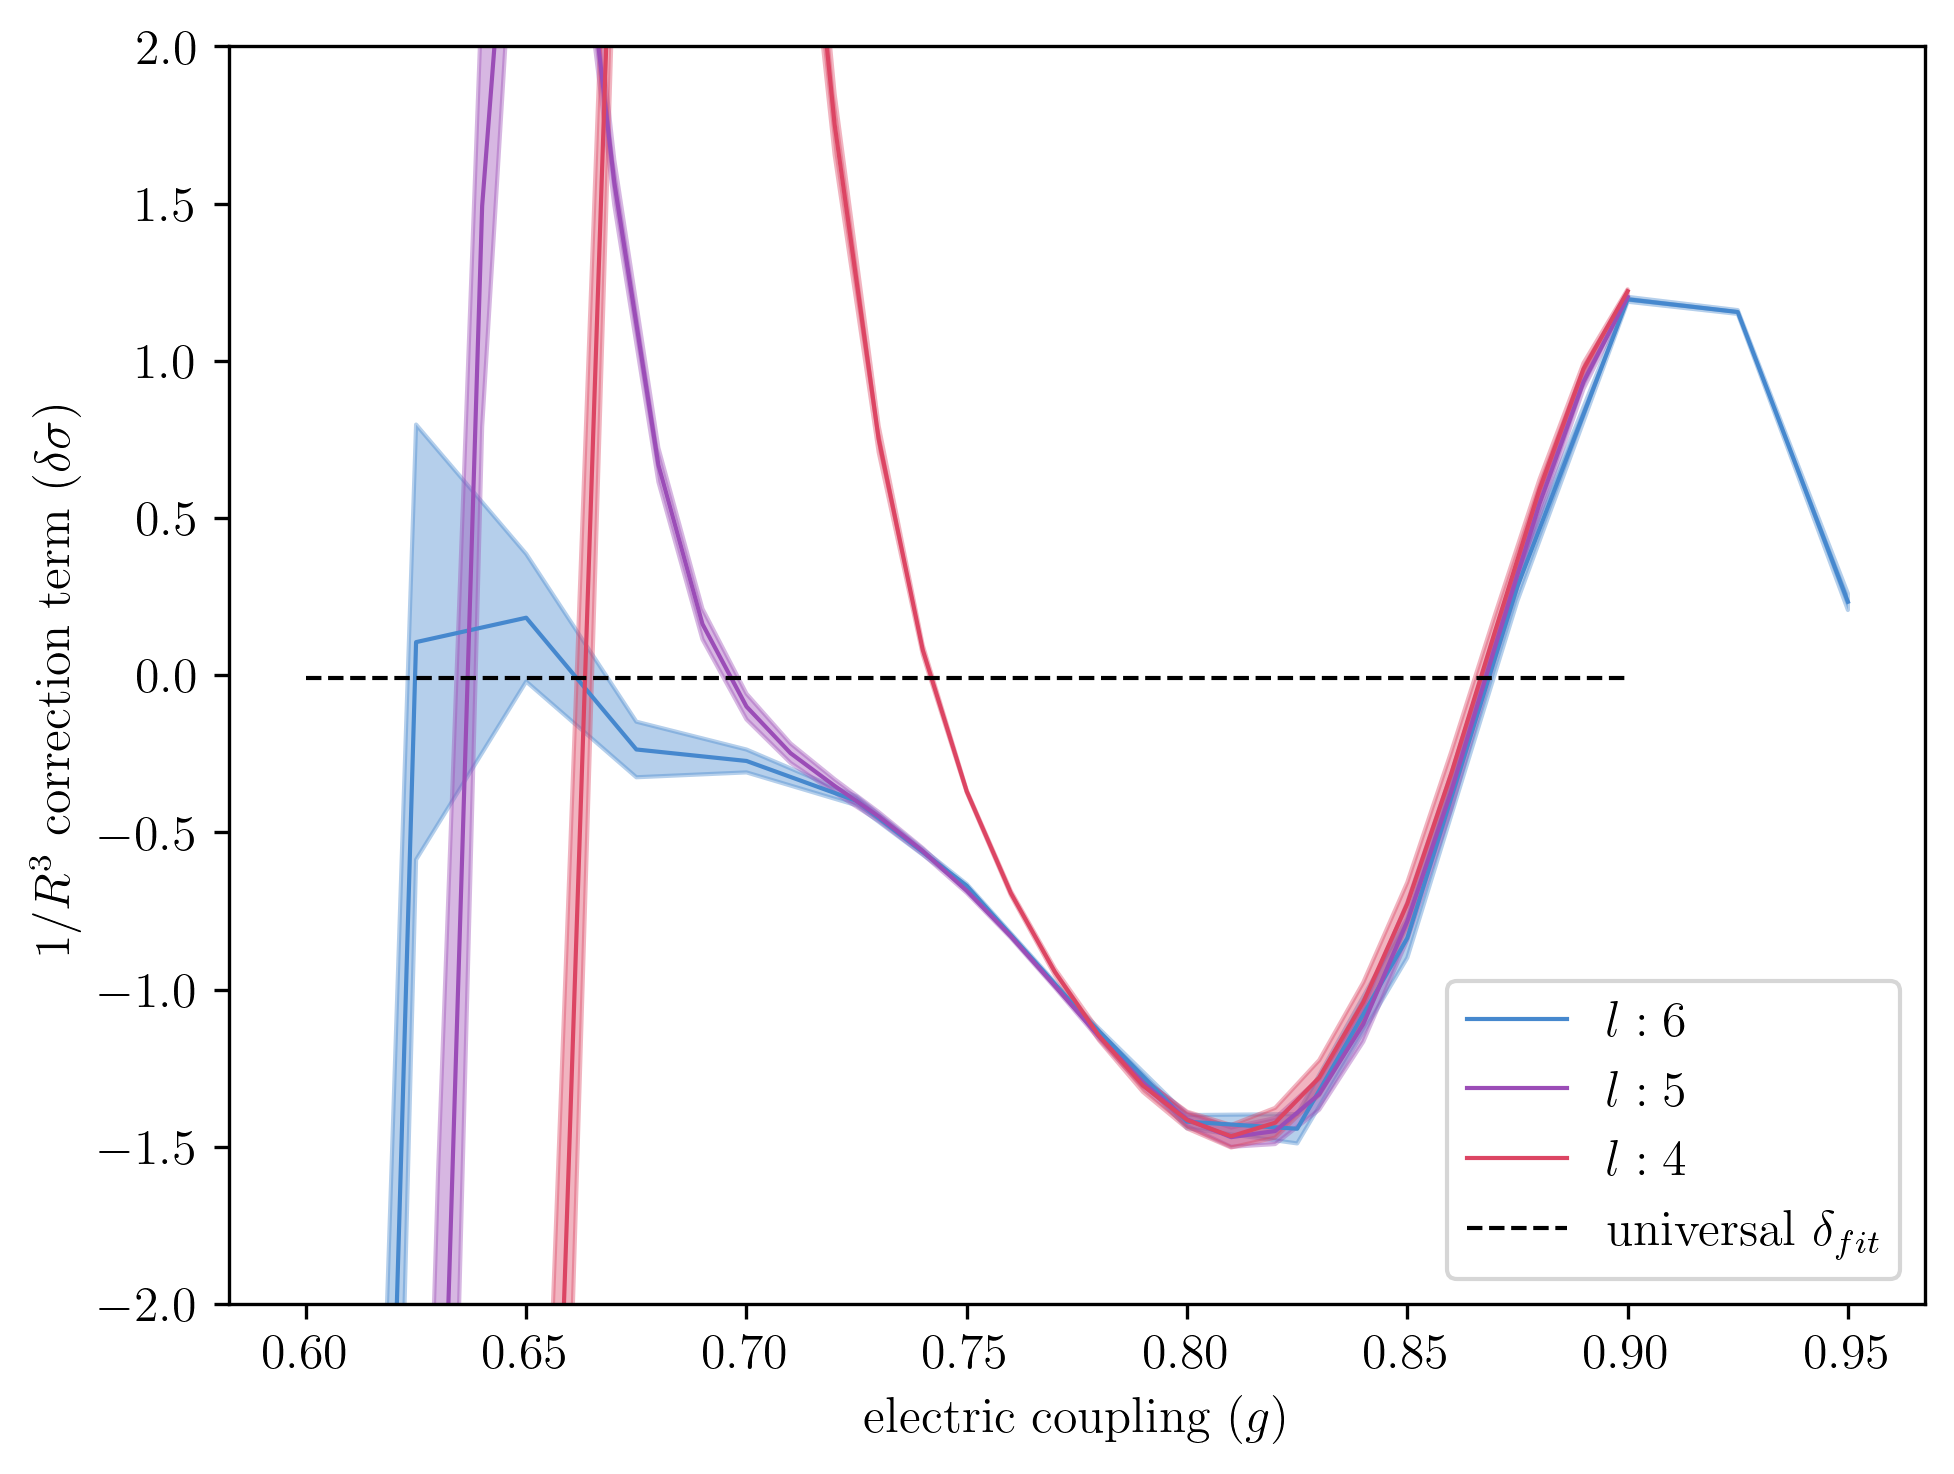

In [40]:
fit = 3

h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,12,13,14,15,16,17,19,21]
l = 6

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[0])


h_i, h_f, npoints = 0.6, 0.9, 31
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128,256]
Rs = [7,8,9,10,11,13,15,17,19,21]
l = 5

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[1])


Rs = [7,8,9,10,11,12,14,16,18,20,22]
l = 4

plot_delta(gs,Rs,l,chis,h_i,h_f,npoints,path,colors[2])

plt.hlines(y=-(np.pi**2)/1152, xmin=gs[0], xmax=gs[-1], linestyles="--", colors='black', linewidth=1, label="universal $\\delta_{fit}$")

# plt.grid(True)
plt.ylim(-2,2)
plt.xlabel("electric coupling $(g)$")
plt.ylabel("$1/R^3$ correction term $(\\delta\\sigma)$")
plt.legend()
plt.savefig(f"{path_figures}/figures/fluxtube/second_potential_correction_fit_ord_{fit}_vs_ladders_{[4,5,6]}_best_Rs_bc_{bc}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chis[-1]}.png")

## String Width

<>:50: SyntaxWarning: invalid escape sequence '\i'
<>:50: SyntaxWarning: invalid escape sequence '\i'
C:\Users\HP\AppData\Local\Temp\ipykernel_25624\115216603.py:50: SyntaxWarning: invalid escape sequence '\i'
  plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")


g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.6
g: 0.625
g: 0.65
g: 0.6749999999999999
g: 0.7
g: 0.725
g: 0.75
g: 0.7749999999999999
g: 0.7999999999999999
g: 0.825
g: 0.85
g: 0.875
g: 0.8999999999999999
g: 0.9249999999999999
g: 0.95
g: 0.4
g: 0.54375
g: 0.6875
g: 0.83125
g: 0.975
g: 1.11875
g: 1.2625
g: 1.40625
g: 1.5499999999999998
g: 1.69375
g: 1.8375
g: 1.9812499999999997
g: 2.125
g: 2.26875
g: 2.4124999999999996
g: 2.55625
g: 2.6999999999999997
g: 2.8437499999999996
g: 2.9875
g: 3.1312499999999996
g: 3.275
g: 3.4187499999999997
g: 3.5624999999999996
g: 3.70625
g: 3.8499999999999996
g: 3.9937499999999995
g: 4.1375
g: 4.28125
g: 4.425
g: 4.56875
g

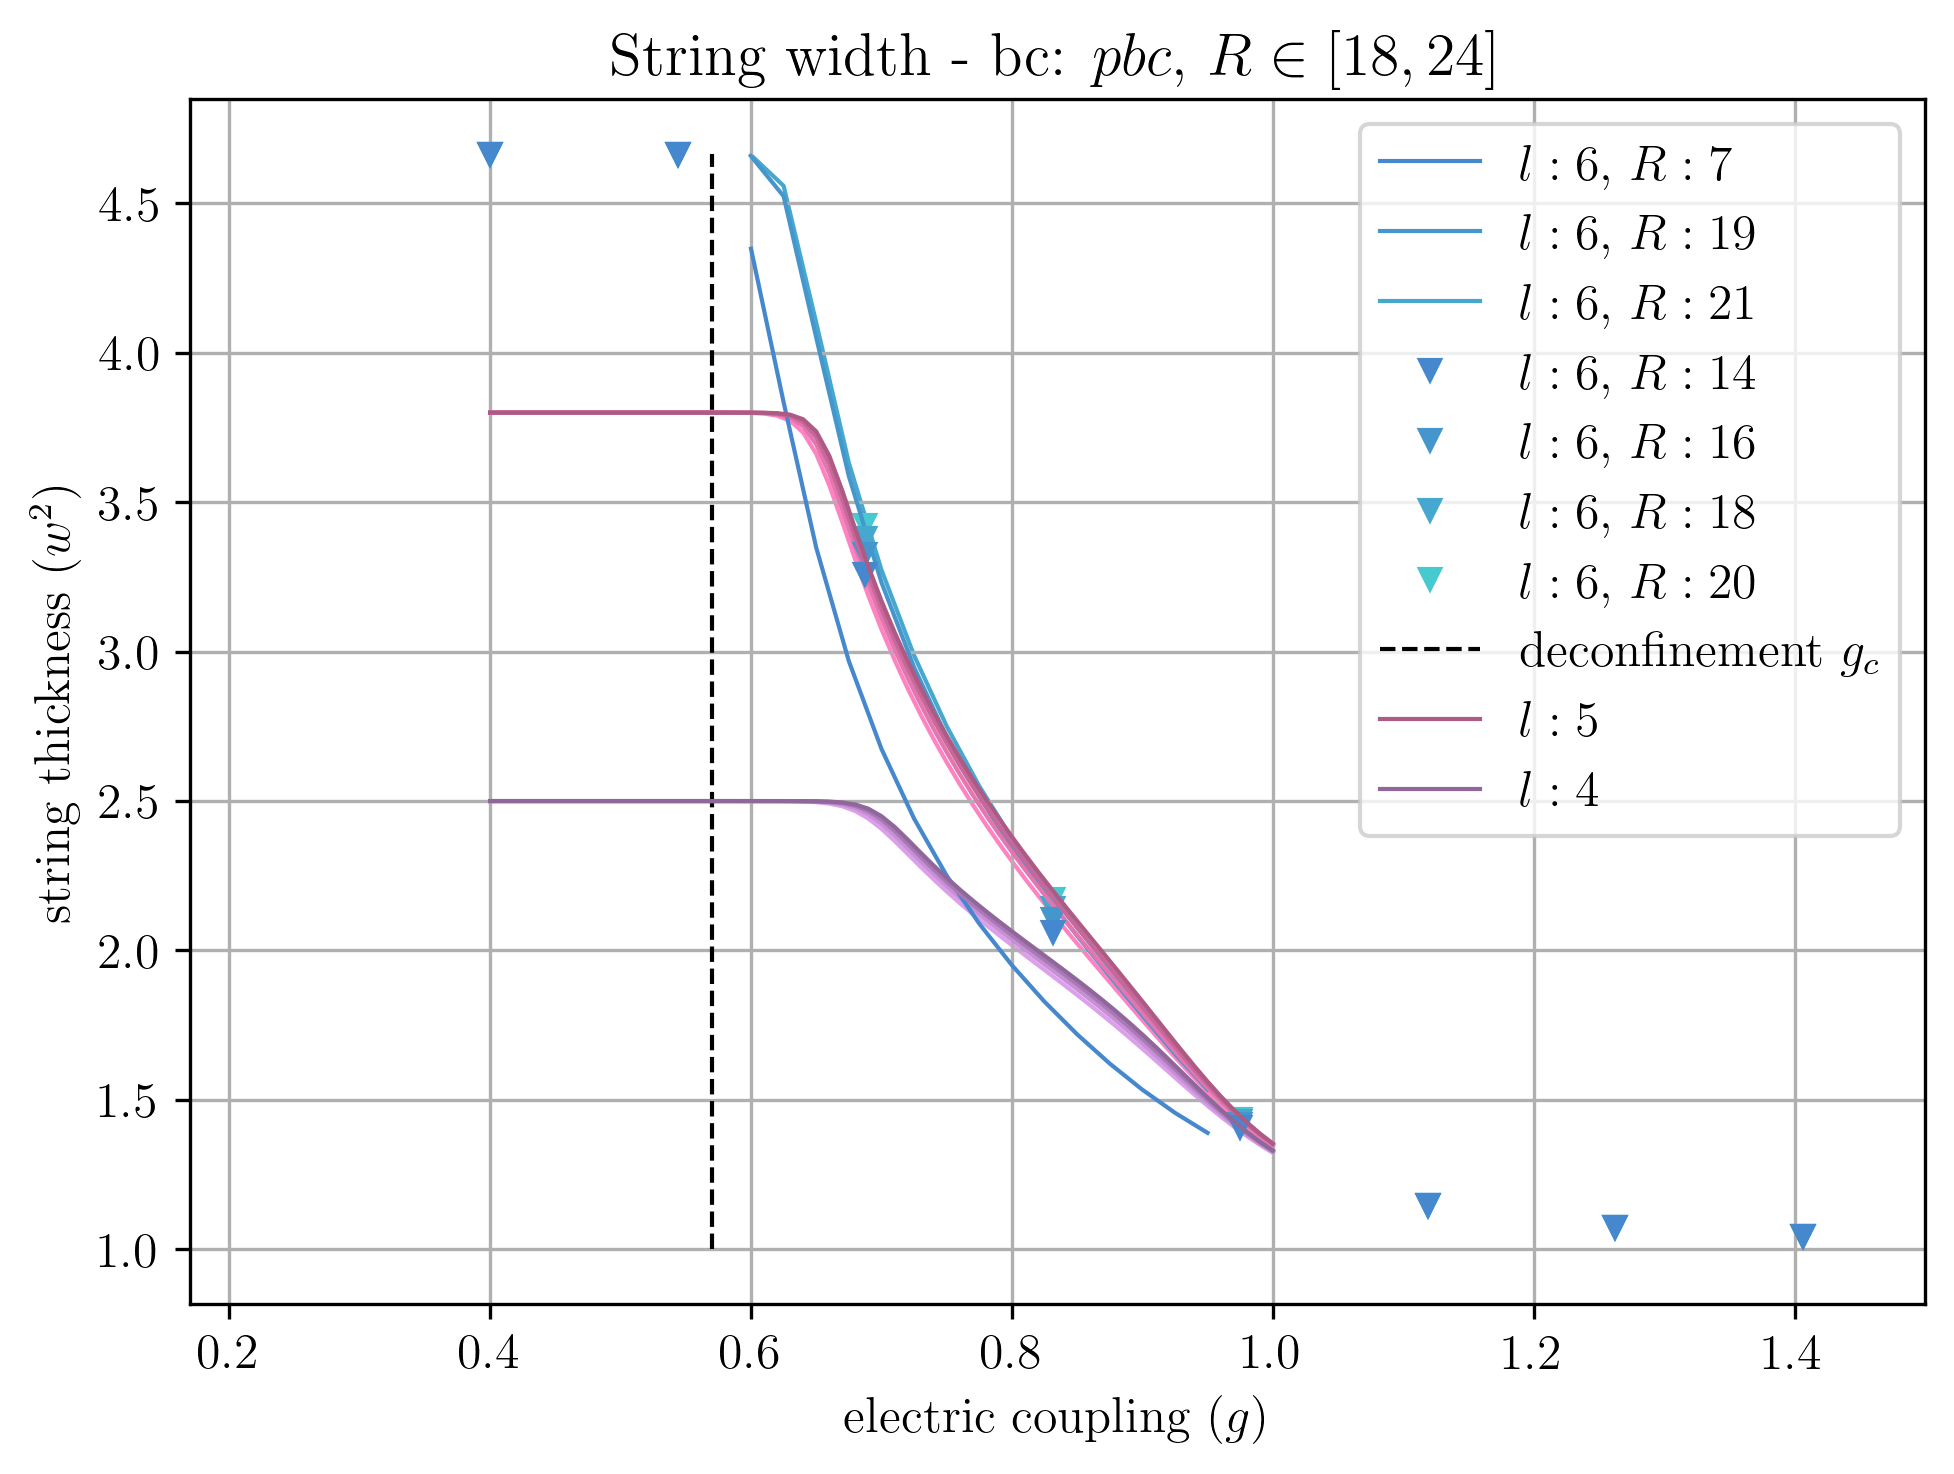

In [19]:
colors = ["#4688CE","#4696CE","#46A8CE","#46CACF"]
Rs = [19,21,23]
Rs.reverse()
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
bc = "pbc"
sector = "2_particle(s)_sector"
l = 6
L = 30
Ls = [30]
chis = [64,128]
Rs = [7,19,21]

for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs, ws, markersize=5, color=colors[i], linestyle="-", linewidth=1, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4)

h_i, h_f, npoints = 0.4, 5.0, 33
gs = np.linspace(h_i,h_f,npoints)
chis = [32,64,128]
Rs = [14,16,18,20]
l = 6
for i, R in enumerate(Rs):
    ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
    plt.plot(gs, ws, marker='v', markersize=5, color=colors[i], linestyle="", linewidth=0, label=f"$l: {l}$, $R: {R}$", zorder=len(Rs)-i)
    # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i+j+1], alpha=0.4)

plt.vlines(x=0.57, ymin=1, ymax=max(ws), linestyles="--", colors='black', linewidth=1, label="deconfinement $g_c$")

chis = [32,64]
Rs = [18,20,22,24]
Rs.reverse()
# colorss = [["#4688CE","#4696CE","#46A8CE","#46CACF"],["#9B4DB7","#BC4FBE","#CC50C2","#DC51C5"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
colorss = [["#AD5A85","#C86799","#E575AF","#FF82C3"],["#90679A","#A979B5","#C78FD5","#DD9FEC"],["#DC4563","#E45A70","#ED7580","#F68F8F"]]
ls = [5,4]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints)
for colors, l in zip(colorss, ls):
    for i, R in enumerate(Rs):
        ws, err_ws = string_width_varying_g(gs,R,l,L,chis,bc,sector,h_i,h_f,npoints,path)
        if R == 24:
            label = f"$l: {l}$"
        else: 
            label = None
        plt.plot(gs, ws, markersize=2, color=colors[i], linestyle="-", linewidth=1, label=label, zorder=len(Rs)-i)
        # plt.fill_between(gs, y1=np.asarray(ws)+np.asarray(err_ws),y2=np.asarray(ws)-np.asarray(err_ws), color=colors[i], alpha=0.4, zorder=len(Rs)-i)

Rs.reverse()
plt.title(f"String width - bc: ${bc}$, $R \in [{Rs[0]},{Rs[-1]}]$")
plt.xlabel("electric coupling $(g)$")
plt.ylabel("string thickness $(w^2)$")
plt.grid(True)
# plt.xscale("log")
plt.xlim(right=1.5)
plt.legend()

## String width occupation

[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0, 1, 2]
[-1, 0

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_4422/3962236167.py:78: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


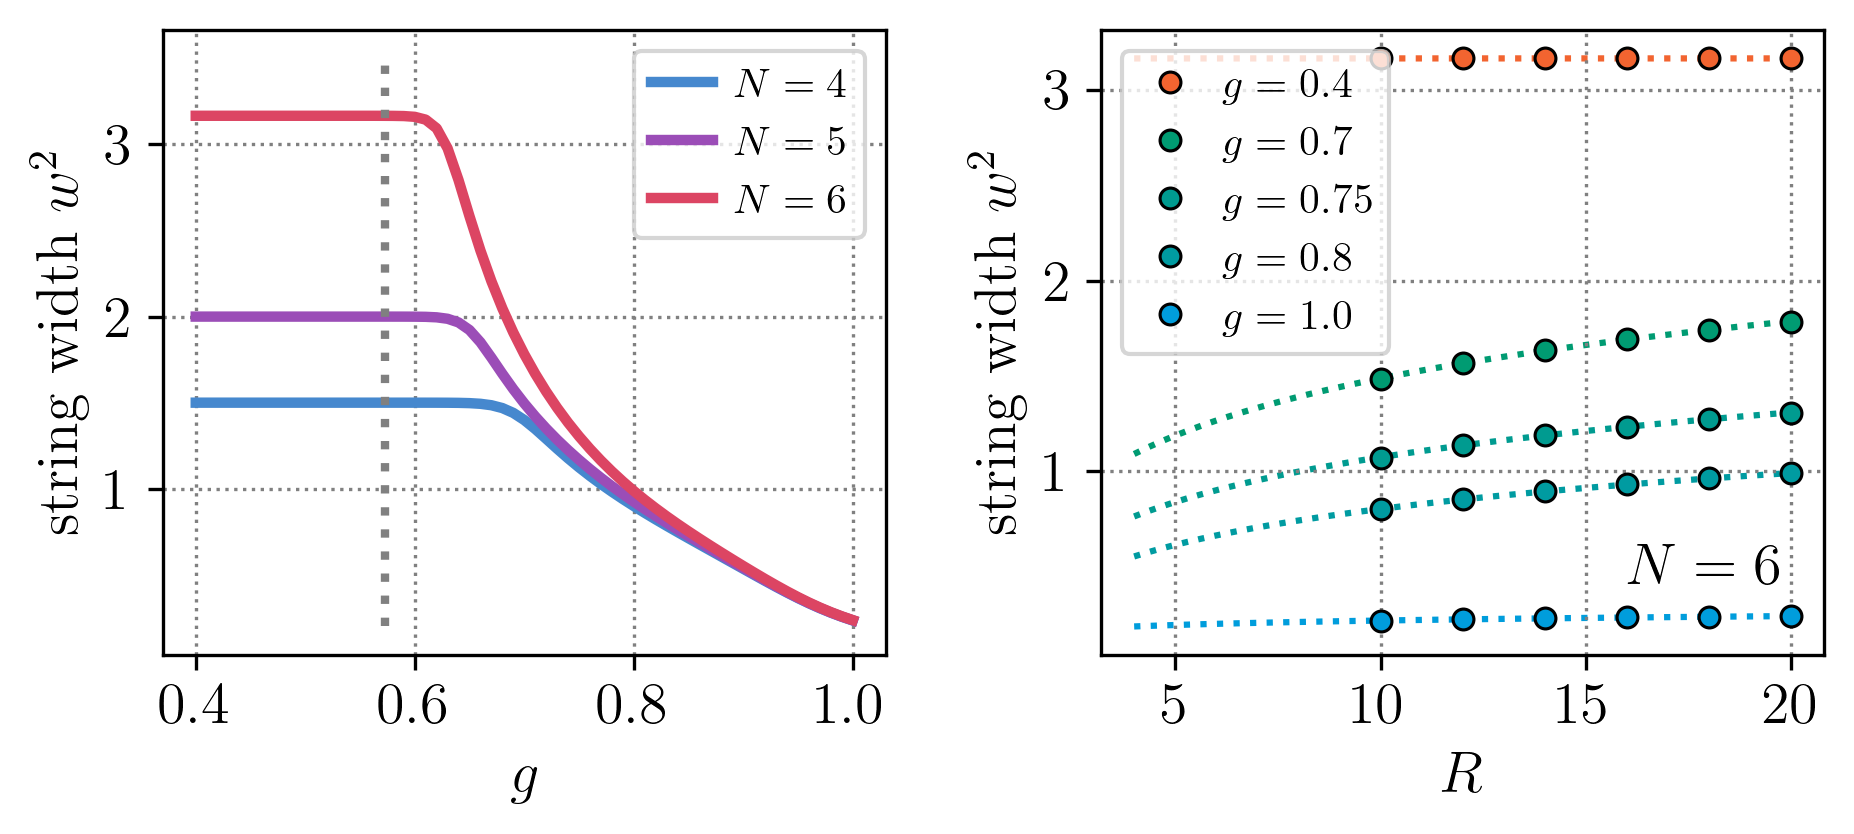

In [70]:
# Matplotlib settings

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

marker_opts = dict(
    marker='o',
    markeredgecolor='k',
    markeredgewidth=0.75,
    markersize=5,
    linestyle='',
)

theor_gc = 1 / np.sqrt(3.04438)
theor_gc
R_max = [20,20,20,19]

Rs = [10,12,14,16,18,20]
h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i, h_f, npoints)
chis = [64,128]

fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

for ax in axs:
    ax.grid(color="gray", linestyle=":")

colors = ["#4688CE","#9B4DB7","#DC4563"]

# String width vs coupling
i = 0
for N in [4, 5, 6]:
    Rmax = R_max[i]
    string_width, string_width_err = string_width_varying_g(gs, Rmax, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    print(f"N = {N}, Rmax = {Rmax}")
    axs[0].plot(gs, string_width, color=colors[i], label=f"$N = {N}$", linewidth=2.5)
    i += 1
axs[0].legend()
axs[0].set_xlabel("$g$")
axs[0].set_ylabel("string width $w^2$")
axs[0].vlines(theor_gc, 0.2, 3.5, 'grey', ':', linewidth=2)
# axs[0].set_ylim(1, 4)


colors = ["#F26430", "#009B72", "#009B90", "#009BA1", "#009DDC"]

# String width vs separation R
k = 0
coupls = [1.0, 0.9, 0.8, 0.7, 0.4]
coupls = [1.0, 0.8, 0.7, 0.4]
coupls = [1.0, 0.8, 0.75, 0.7, 0.4]
coupls.reverse()

def log_fit(R, a, b):
    return a*np.log(R) + b

for g in coupls:
    string_width, string_width_err = string_width_varying_R(g, Rs, N, L, chis, bc, sector, h_i, h_f, npoints, path, occupation=True)
    axs[1].plot(Rs, string_width, color=colors[k], label=f"$g = {g}$", **marker_opts)
    
    plog, clog = curve_fit(log_fit, Rs, string_width)
    x_fit = np.linspace(4,20)
    axs[1].plot(x_fit, log_fit(x_fit,*plog), color=colors[k], linestyle=':', zorder=0)
    k += 1

axs[1].set_xlabel("$R$")
axs[1].set_ylabel("string width $w^2$")
axs[1].legend(loc="upper left")
axs[1].text(16, 0.4, f"$N = {N}$")

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/string_width.pdf", bbox_inches='tight', format='pdf')

## Fidelity Susceptibility

C:\Users\HP\AppData\Local\Temp\ipykernel_31600\1580192481.py:105: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


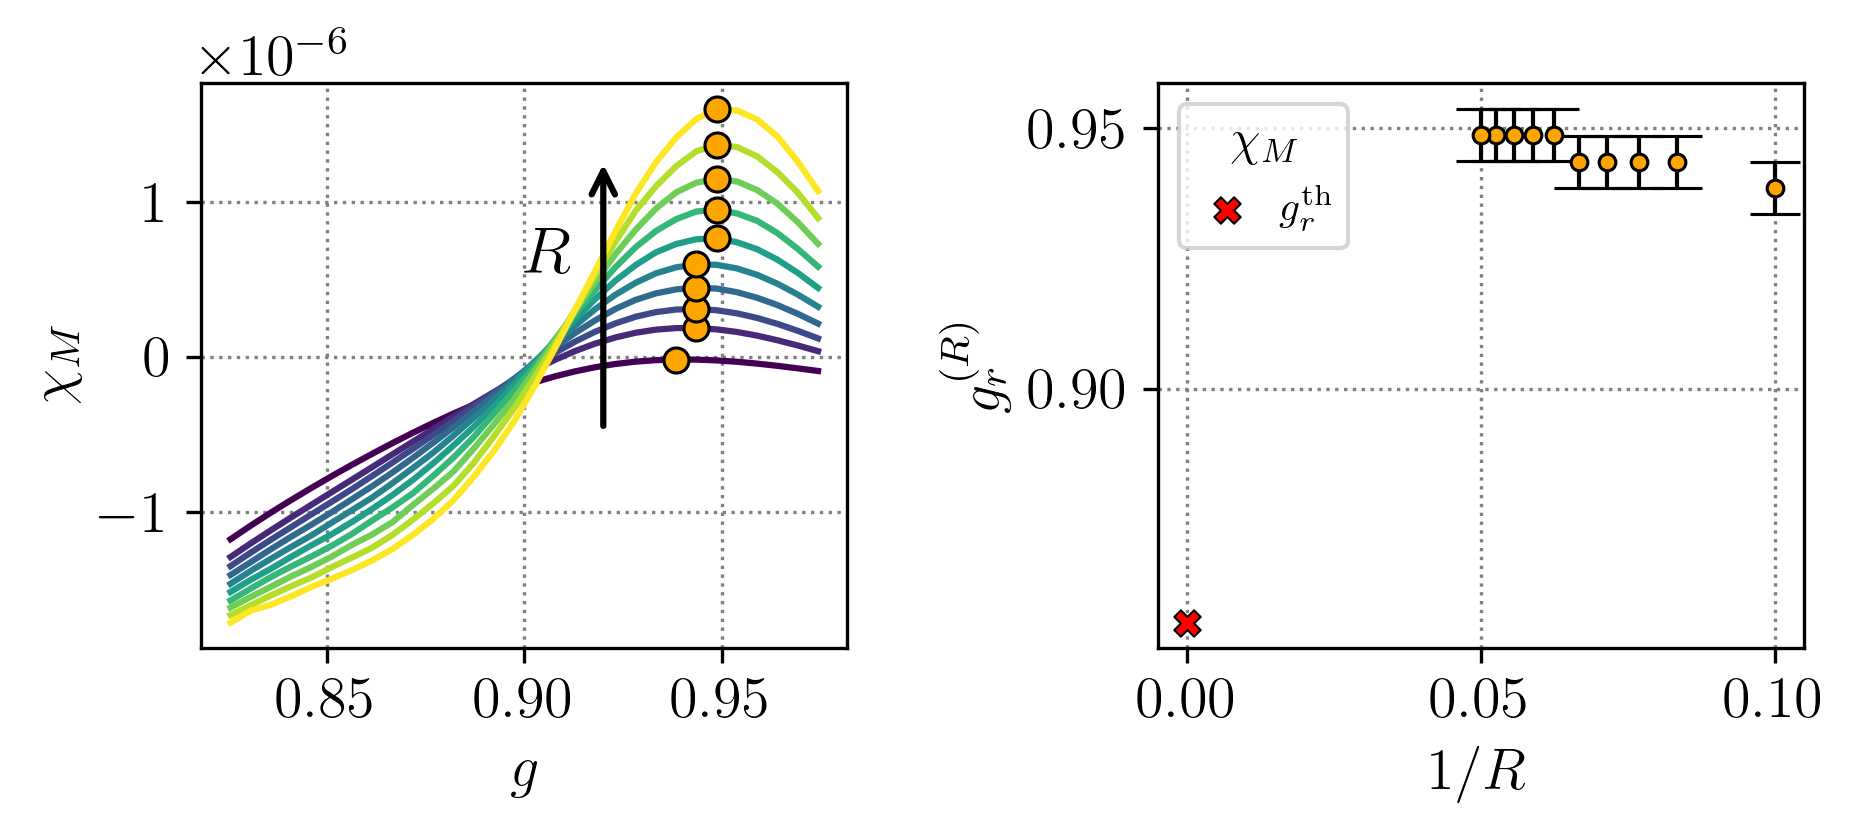

In [143]:
l = 6
L = 30 
bc = "pbc"
h_i, h_f, npoints = 0.6, 0.95, 15
Rs = [10,11,13,15,16,17,19,21]
chi = 256

h_i, h_f, npoints = 0.4, 1.0, 61
gs = np.linspace(h_i,h_f,npoints-1)
Rs = [10,12,13,14,15,16,17,18,19,20]
chi = 128
rng = [45,-2]
x_arrow = 0.92
y_bottom = -0.5e-5
y_top = +1.5e-5

l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints-1)
Rs = [10,12,13,14,15,16,17,18,19,20]
chi = 128
rng = [5,-5]
x_arrow = 0.92
y_bottom = -0.5e-6
y_top = +1.3e-6

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75
)

colors = create_sequential_colors(len(Rs))
log = False
rdm = False

fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

for ax in axs:
    ax.grid(color="gray", linestyle=":")

max_g = []
for i, R in enumerate(Rs):
    fidelities = np.load(f"{path}/results/overlap/fidelity_susceptibility_log_{log}_rdm_{rdm}_{model}_{l}x{L}_bc_{bc}_R_{R}_npoints_{npoints}_h_{h_i}-{h_f}_chi_{chi}.npy")
    # Susceptibility
    axs[0].plot(gs[rng[0]:rng[1]], fidelities[rng[0]:rng[1]], color=colors[i])
    axs[0].scatter(gs[rng[0]:rng[1]][np.argmax(fidelities[rng[0]:rng[1]])], np.max(fidelities[rng[0]:rng[1]]), **peaks_opts)
    axs[0].set_ylabel(r"$\chi_M$")
    axs[0].set_xlabel(r"$g$")
    max_g.append(gs[rng[0]:rng[1]][np.argmax(fidelities[rng[0]:rng[1]])])


# Double-headed arrow
axs[0].annotate(
    '', xy=(x_arrow, y_top), xytext=(x_arrow, y_bottom),
    arrowprops=dict(arrowstyle='->', color='black', linewidth=1.5)
)

# Label next to the arrow
axs[0].text(
    x_arrow - 0.02, 4 * (y_top + y_bottom) / 5,  # small x shift, mid y
    r'$R$', fontsize=16, va='center'
)

err_g = (h_f - h_i) / (npoints - 1)
labels=dict(
        fit="$a L^{-1} + b$",
        theor="$g_r^{\\mathrm{th}}$"
    )
theor_y0 = 0.855
fss_plot_opts = dict(
    fit_opts = dict(linestyle="--", linewidth=1, color="k"),
    y0_opts = dict(fmt='s', elinewidth=1, ecolor="k", capsize=6, markersize=5, mfc="red", mec="k", mew=0.5, capthick=2),
    theor_opts = dict(s=40, marker='X', facecolors="red", edgecolors="k", linewidths=0.5),
    points_opts = dict(fmt='o', elinewidth=1, ecolor="k", capsize=6, ms=4, mfc="orange", mec="k", mew=0.75, capthick=2)
)


# Plot fitted function
# xrange = np.linspace(0, 1/fss.data[fss.x].min())
# fitted_fs = fss.fit_func(xrange, *fss.fit_params)
# fit_plot, = ax.plot(xrange, fitted_fs, label=labels.get("fit", ""), **fit_opts)

# Plot fss data
axs[1].errorbar(
    [1 / R for R in Rs],
    max_g,
    err_g,
    label=labels.get("points", ""),
    **fss_plot_opts["points_opts"]
)

# Theoretical value for y0
axs[1].scatter([0.0], [theor_y0], label=labels.get("theor"), **fss_plot_opts["theor_opts"], zorder=20)

# # Plot point at x = 0
# axs[1].errorbar(0, fss.y0, fss.y0_err, label=labels.get("y0", ""), **y0_opts)

axs[1].legend(title="$\\chi_M$")
axs[1].set_ylabel("$g_r^{(R)}$")
axs[1].set_xlabel(r"$1/R$")

fig.tight_layout()

# Save figure
fig.savefig(f"{path_figures}/figures/fluxtube/fid_susc_{l}x{L}.pdf", bbox_inches="tight")

In [55]:
max_g

[0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9491525423728814,
 0.9593220338983051]

## Time

### Entropy

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_4422/1836153847.py:131: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


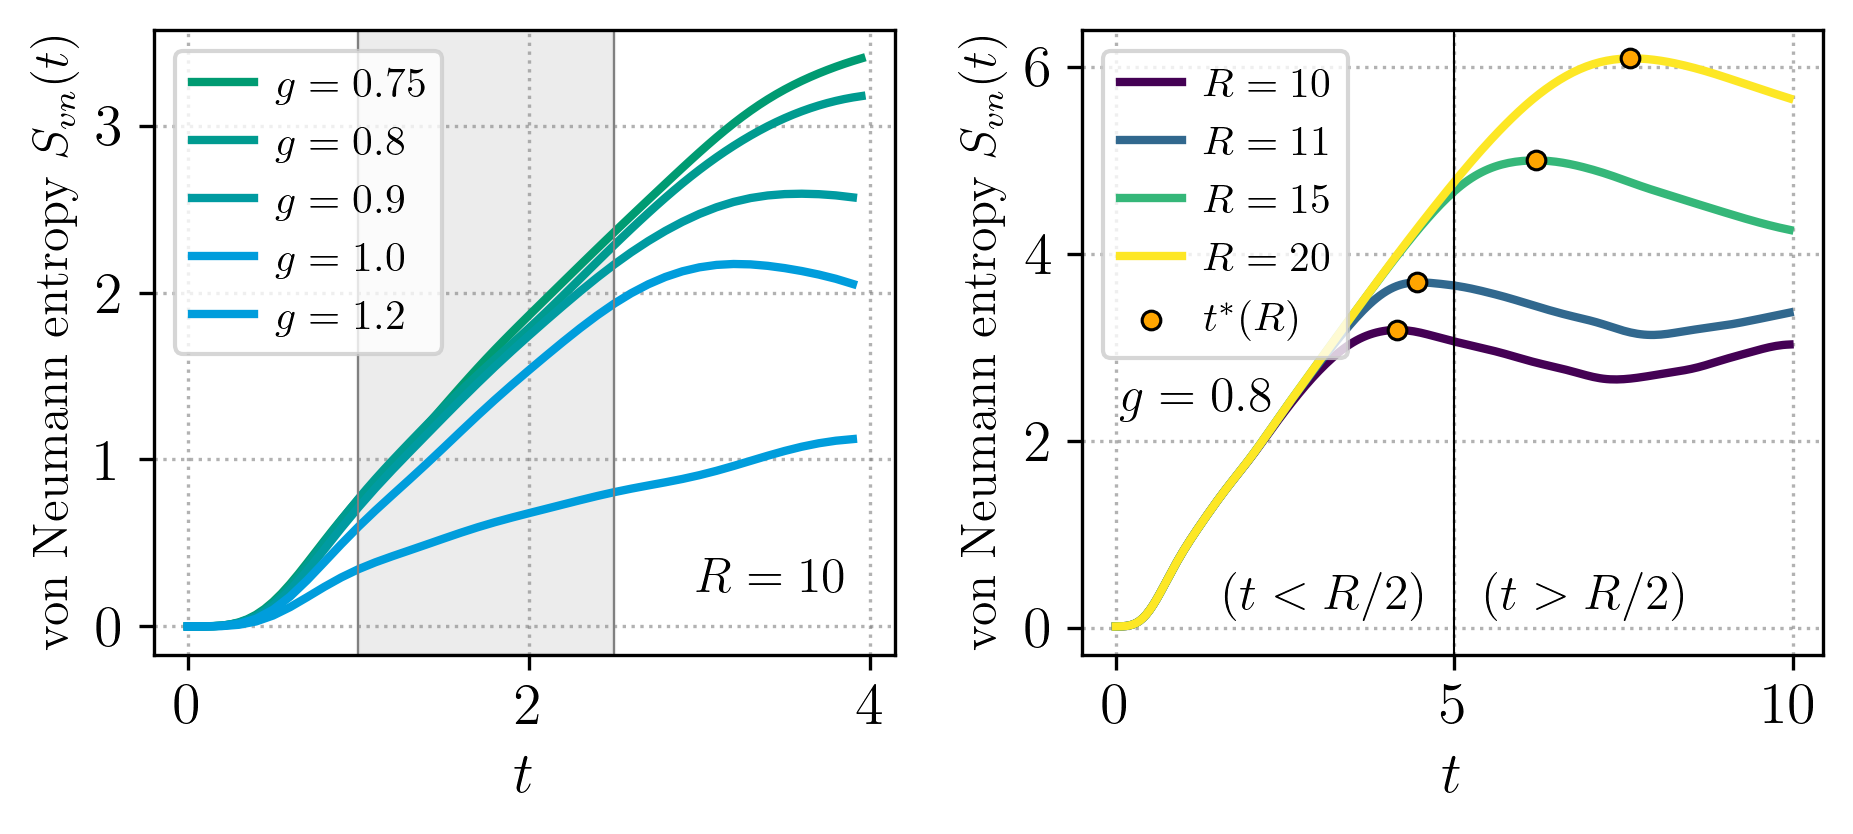

In [26]:
R = 10
chi = 128
of = 0.2

l = 5

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

# fig, axs[0] = plt.subplots(figsize=(4.5, 3))
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

#################
# ENTROPY vs g
#################
for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

ws_g_rough = []
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)
# his = [0.9, 1.0]

ws_g_conf = []
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_conf.append(obs)
    # ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

x_start = 1.0
x_end = 2.5

# Add vertical lines
axs[0].axvline(x_start, color='gray', linestyle='-', linewidth=0.5)
axs[0].axvline(x_end, color='gray', linestyle='-', linewidth=0.5)

# Add shaded area
axs[0].axvspan(x_start, x_end, color='gray', alpha=0.15, zorder=0)


axs[0].set_xlabel(r"$t$")
# axs[0].set_ylabel("von Neumann entropy $S_{vn}(t)$")
# axs[0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$")
axs[0].set_ylabel("von Neumann entropy $S_{vn}(t)$", fontsize=12)
axs[0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$", fontsize=12)


# axs[0].text(0, 1.3, "$a t + b \\quad (t < R/2)$", fontsize=10)

axs[0].legend()


#################
# ENTROPY vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx = []
for i, R in enumerate(Rs):
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = entr_t[1:]
    saturation_idx.append(np.argmax(obs))
    axs[1].plot(delta*np.arange(steps), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")
    if R == Rs[-1]:
        label="$t^*(R)$"
    else:
        label=None
    axs[1].scatter(delta*np.arange(steps)[np.argmax(obs)], np.max(obs), label=label, **peaks_opts)

axs[1].axvline(10/2, color='k', linestyle='-', linewidth=0.5)
# axs[1].text(10/2-3.3, 0.2, f"$(t < R/2)$")
# axs[1].text(10/2+0.45, 0.2, f"$(t > R/2)$")
axs[1].text(10/2-3.4, 0.2, f"$(t < R/2)$", fontsize=12)
axs[1].text(10/2+0.45, 0.2, f"$(t > R/2)$", fontsize=12)

axs[1].set_xlabel(r"$t$")
# axs[1].set_ylabel("von Neumann entropy $S_{vn}(t)$")
# axs[1].text(0.05, 2.3, f"$g = {h_ev}$")

axs[1].set_ylabel("von Neumann entropy $S_{vn}(t)$", fontsize=12)
axs[1].text(0.05, 2.3, f"$g = {h_ev}$", fontsize=12)

axs[1].legend()

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/entropy_in_time_{l}x{L}_Rs_{Rs}_gs_{coupls}_with_one_v_line.pdf", bbox_inches="tight")

In [27]:
slope_interval = [1,2.5] # in t
c = 1

def lin_func(x,a,b):
    return a*x + b

delta = 0.01
# delta = 0.02
steps = 400
# steps = 500
his = [ 0.75, 0.8]
# his = [0.8]
slopes = []
slopes_err = []
where_slope = np.argwhere([i if t in slope_interval else 0 for i,t in enumerate(delta*np.arange((steps)+1))])
xs = np.linspace(slope_interval[0], slope_interval[1], int(where_slope[1,0]*of)-int(where_slope[0,0]*of))
for j, ws_t in enumerate(ws_g_rough):
    ys = ws_t[int(where_slope[0,0]*of):int(where_slope[1,0]*of)]
    # plt.plot(xs, ys, marker='^', color=colors[j], label=f"$g: {his[j]}$")
    popt, cov = curve_fit(lin_func, xs, ys)
    err = np.sqrt(np.diag(cov))
    print(f"slope for g: {his[j]} is a: {popt[0]:.3f}+/-{err[0]:.3f}")
    
    slopes.append(popt[0])
    slopes_err.append(err[0])

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200

plin, clin = curve_fit(lin_func, Rs, [delta*np.arange(steps)[idx] for idx in saturation_idx])
err = np.sqrt(np.diag(clin))
for j, R in enumerate(Rs):
    print(f"saturation time t* for R: {Rs[j]} is: {delta*np.arange(steps)[saturation_idx[j]]}")

print(f"avg slope: {np.mean(slopes):.3f}+/-{np.sum(slopes_err):.3f}")
print(f"t* dependency on R: {plin[0]:.3f}+/-{err[0]:.3f}")


slope for g: 0.75 is a: 1.043+/-0.006
slope for g: 0.8 is a: 0.960+/-0.005
saturation time t* for R: 10 is: 4.15
saturation time t* for R: 11 is: 4.45
saturation time t* for R: 15 is: 6.2
saturation time t* for R: 20 is: 7.6000000000000005
avg slope: 1.001+/-0.011
t* dependency on R: 0.352+/-0.026


### String width

[-2, -1, 0, 1, 2]
[False, False, False, False, False]
OHHHHOOOOH
[[       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan -0.7915834        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan   

/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_4422/2117835751.py:124: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


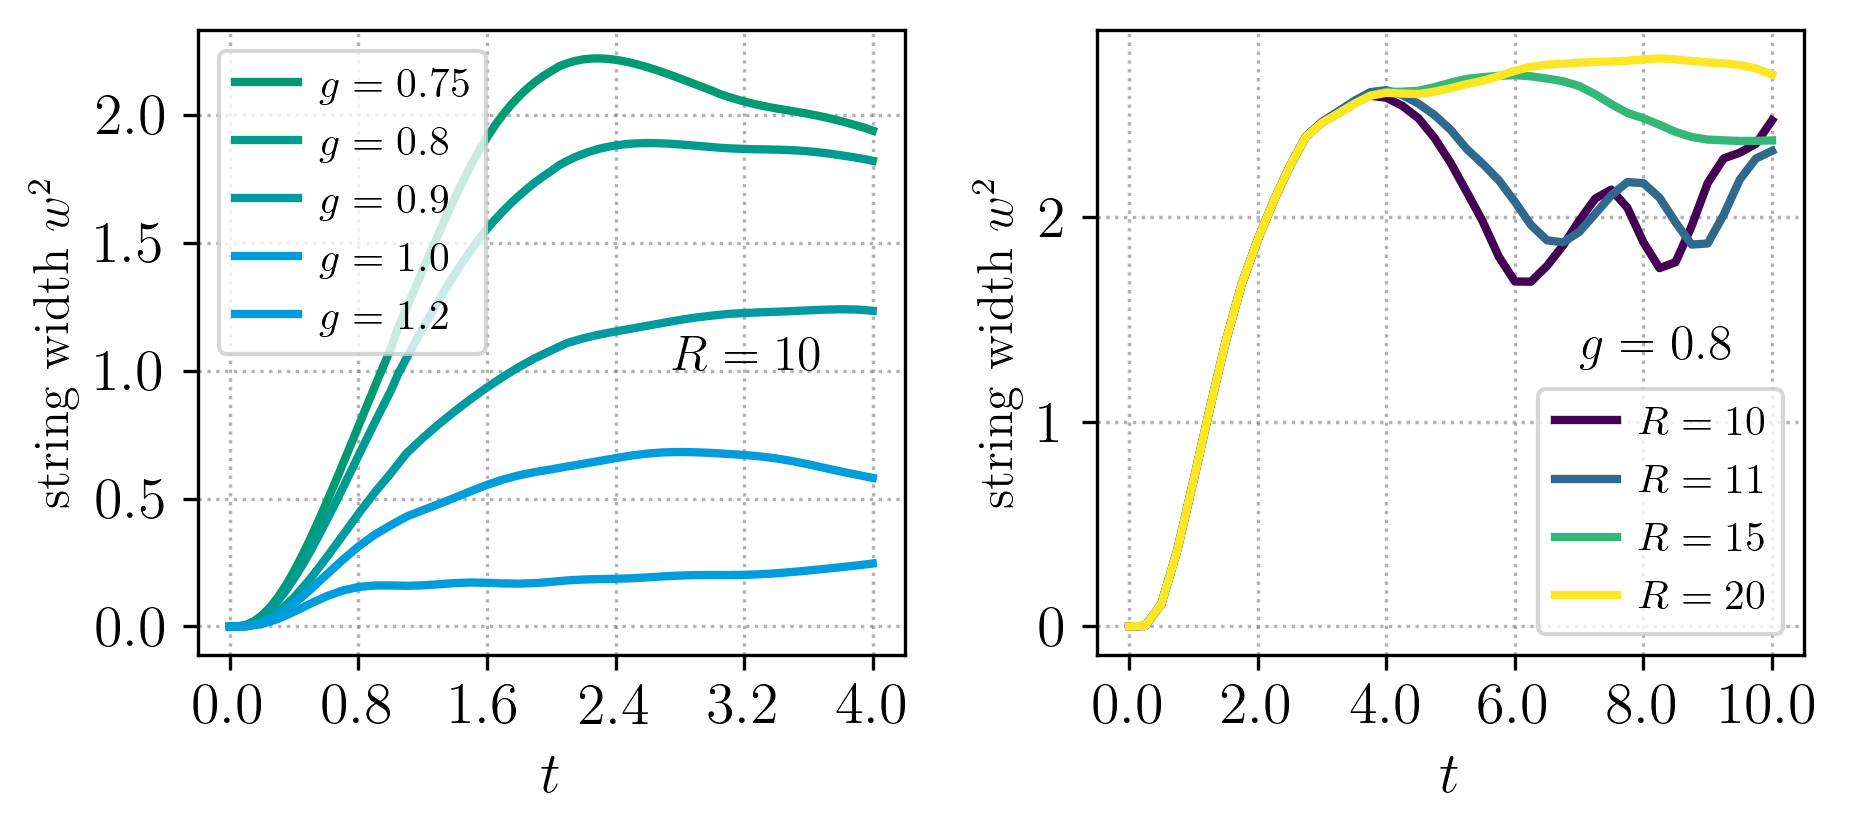

In [36]:
R = 10
chi = 128
of = 0.2

l = 5

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

# fig, axs[0] = plt.subplots(figsize=(4.5, 3))
fig, axs = plt.subplots(1, 2, figsize=(6.4, 3))

#################
# ENTROPY vs g
#################
for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

ws_g_rough = []
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    # obs[0] = 1
    ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange((steps*of)+1), obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)
# his = [0.9, 1.0]

ws_g_conf = []
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    # obs[0] = 1
    print(obs) 
    ws_g_conf.append(obs)
    # ws_g_rough.append(obs)
    axs[0].plot(delta*np.arange((steps*of)+1), obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

axs[0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[0].set_xlabel(r"$t$")
axs[0].set_ylabel("string width $w^2$", fontsize=12)
axs[0].text(0.55, 1, f"$R = {R}$", fontsize=12)


# x_start = 1.0
# x_end = 2.5

# # Add vertical lines
# axs[0].axvline(x_start, color='gray', linestyle='-', linewidth=0.5)
# axs[0].axvline(x_end, color='gray', linestyle='-', linewidth=0.5)

# # Add shaded area
# axs[0].axvspan(x_start, x_end, color='gray', alpha=0.15, zorder=0)


# axs[0].set_xlabel(r"$t$")
# axs[1].set_ylabel("string width $w^2$")
# axs[0].text(delta*np.arange(steps)[-1]-0.9, 0.2, f"$R = {R}$")
# # axs[0].text(0, 1.3, "$a t + b \\quad (t < R/2)$", fontsize=10)

axs[0].legend()


#################
# ENTROPY vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx = []
for i, R in enumerate(Rs):
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    # obs[0] = 1
    print(obs) 
    saturation_idx.append(np.argmax(obs))
    axs[1].plot(delta*np.arange((steps*of)+1), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")
#     if R == Rs[-1]:
#         label="$t^*(R)$"
#     else:
#         label=None
#     axs[1].scatter(delta*np.arange((steps*of)+1)[np.argmax(obs)], np.max(obs), label=label, **peaks_opts)

# axs[1].axvline(10/2, color='k', linestyle='-', linewidth=0.5)
# axs[1].text(10/2-3.3, 0.2, f"$(t < R/2)$")
# axs[1].text(10/2+0.45, 0.2, f"$(t > R/2)$")

axs[1].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[1].set_xlabel(r"$t$")
axs[1].set_ylabel("string width $w^2$", fontsize=12)
axs[1].text(1.4, 1.3, f"$g = {h_ev}$", fontsize=12)

axs[1].legend()

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/string_width_in_time_{l}x{L}_Rs_{Rs}_gs_{coupls}_with_one_v_line.pdf", bbox_inches="tight")

### Entropy and string width

[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]
[-2, -1, 0, 1, 2, 3]


/var/folders/d1/c6hqhfn161x458f4d0m3_rm80000gp/T/ipykernel_4422/2528176349.py:206: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


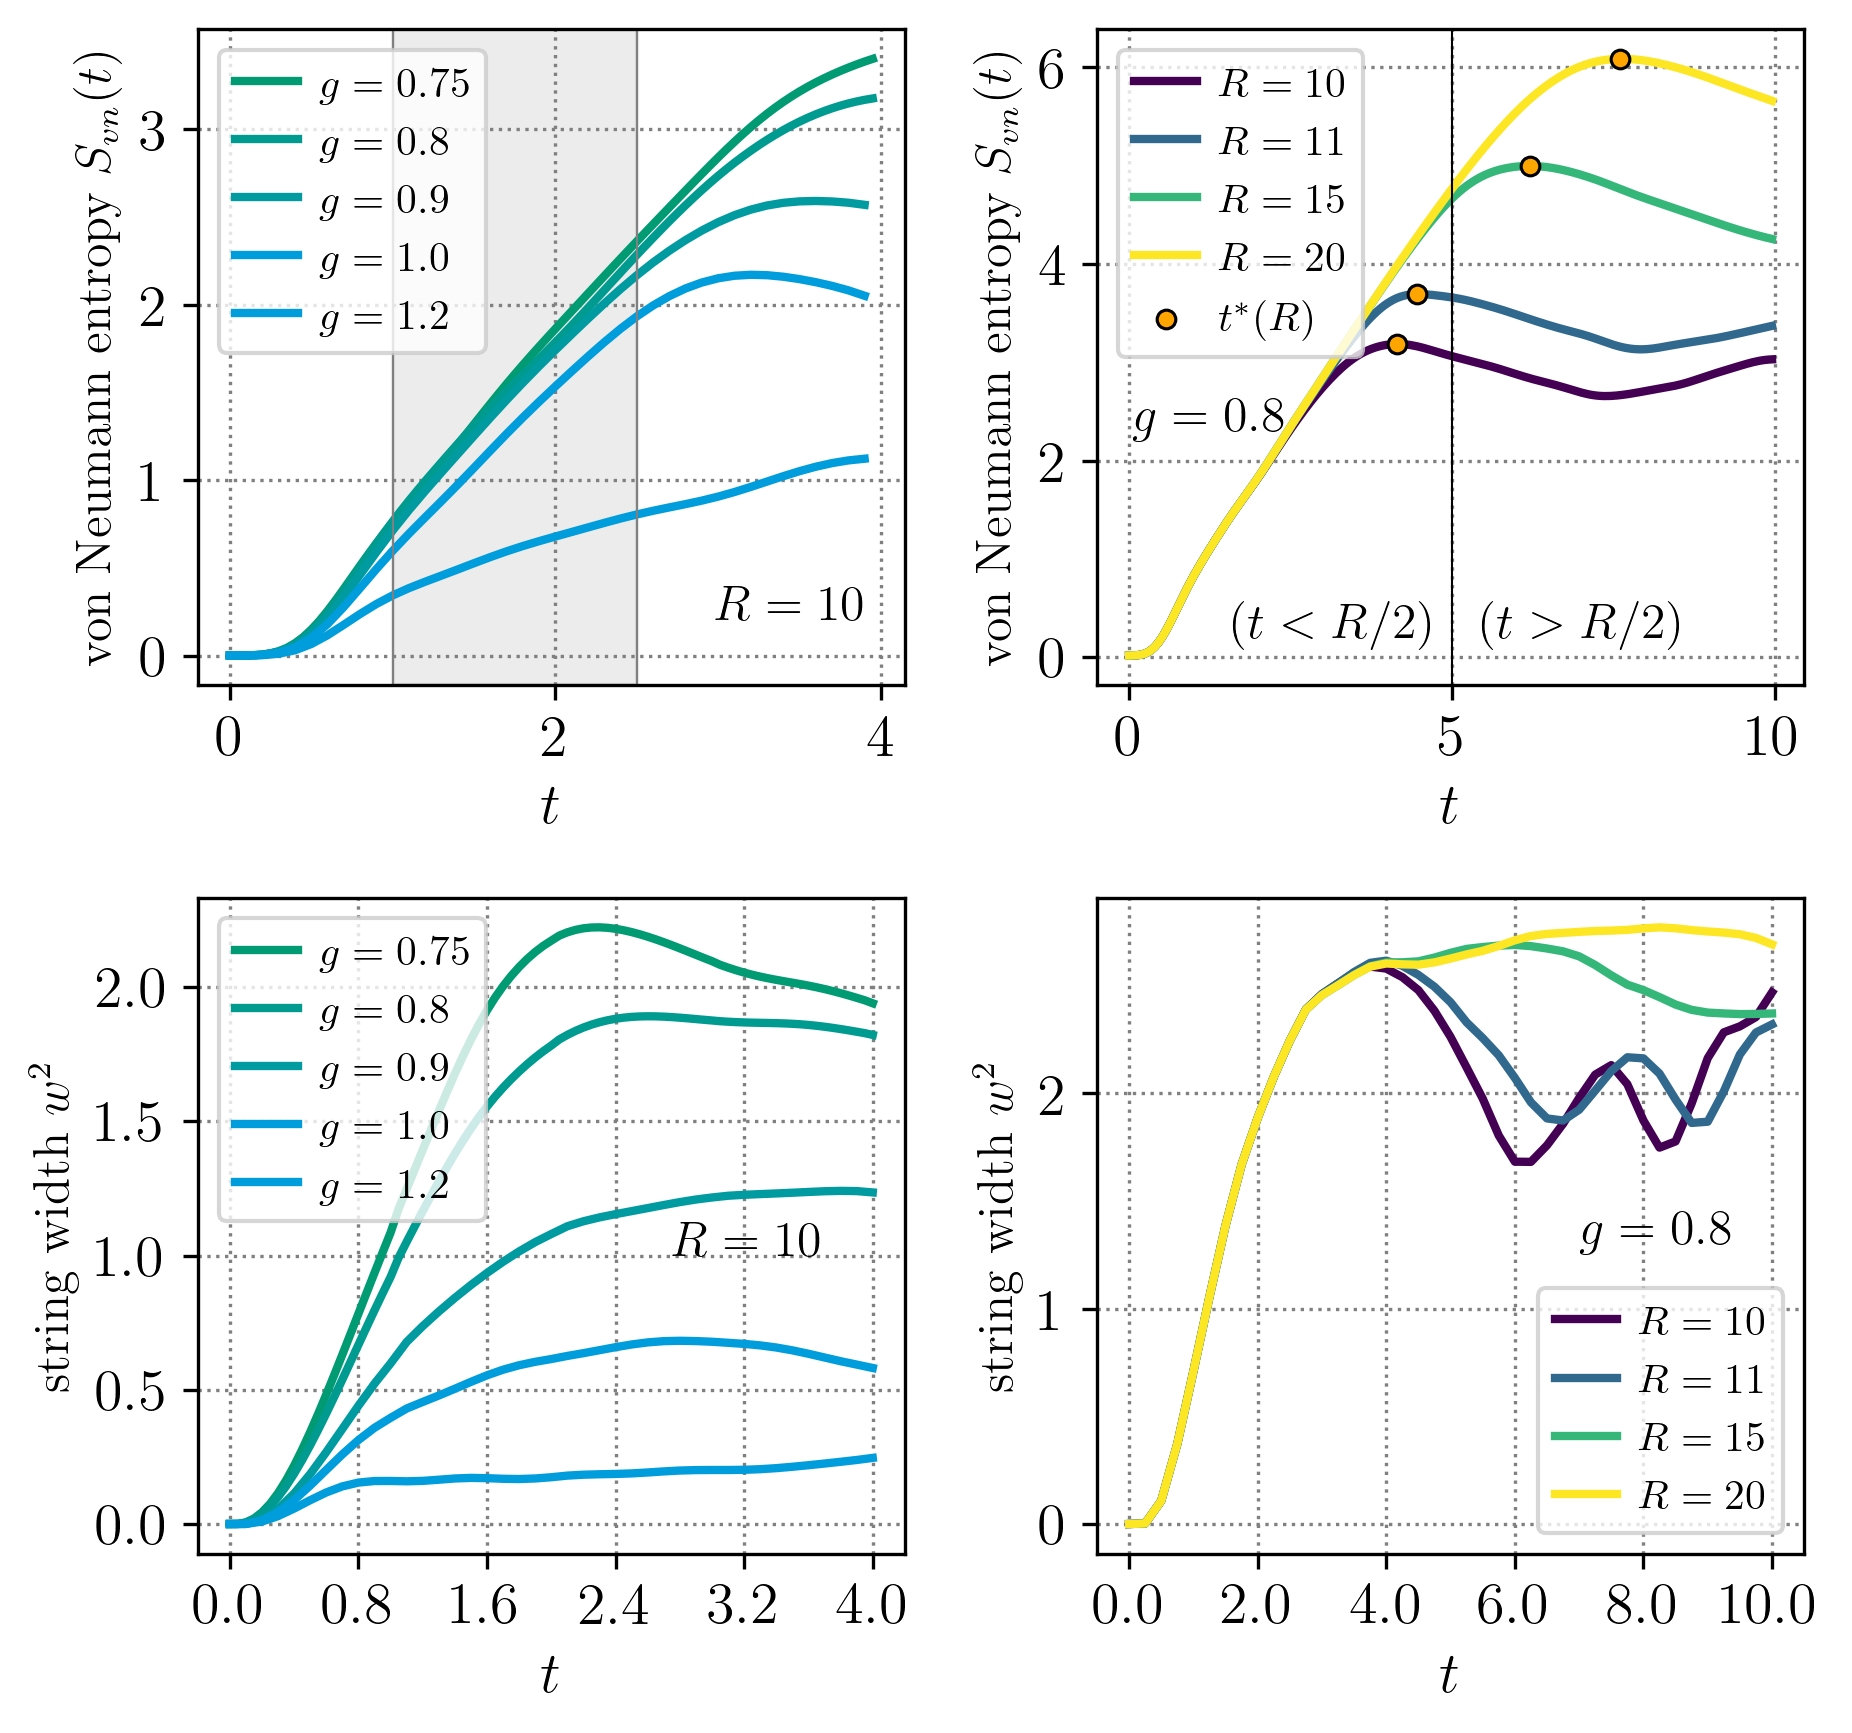

In [61]:
R = 10
chi = 128
of = 0.2

l = 5

plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 14,
    'text.usetex': True,
    'legend.handlelength': 1.5,
    'legend.handletextpad': 0.5,
    'legend.title_fontsize': 12,
    'legend.fontsize': 10
})

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

fig, axs = plt.subplots(2, 2, figsize=(6.4, 6.0))

#################
# ENTROPY vs g
#################

for ax in axs.flatten():
    ax.grid(color="gray", linestyle=":")

ws_g_rough = []
for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_rough.append(obs)
    axs[0][0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)
# his = [0.9, 1.0]

ws_g_conf = []
for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = (entr_t[1:] - entr_t[1])[::int(1/of)]
    ws_g_conf.append(obs)
    # ws_g_rough.append(obs)
    axs[0][0].plot(delta*np.arange(steps)[::int(1/of)], obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

x_start = 1.0
x_end = 2.5

# Add vertical lines
axs[0][0].axvline(x_start, color='gray', linestyle='-', linewidth=0.5)
axs[0][0].axvline(x_end, color='gray', linestyle='-', linewidth=0.5)

# Add shaded area
axs[0][0].axvspan(x_start, x_end, color='gray', alpha=0.15, zorder=0)


axs[0][0].set_xlabel(r"$t$")
# axs[0][0].set_ylabel("von Neumann entropy $S_{vn}(t)$")
# axs[0][0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$")
axs[0][0].set_ylabel("von Neumann entropy $S_{vn}(t)$", fontsize=12)
axs[0][0].text(delta*np.arange(steps)[-1]-1.0, 0.2, f"$R = {R}$", fontsize=12)


# axs[0][0].text(0, 1.3, "$a t + b \\quad (t < R/2)$", fontsize=10)

axs[0][0].legend()


#################
# ENTROPY vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx = []
for i, R in enumerate(Rs):
    entr_t = time_entropy(R,l,L,chi,bc,sector,h_i,h_ev,path,delta=delta,trotter=steps)
    obs = entr_t[1:]
    saturation_idx.append(np.argmax(obs))
    axs[0][1].plot(delta*np.arange(steps), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")
    if R == Rs[-1]:
        label="$t^*(R)$"
    else:
        label=None
    axs[0][1].scatter(delta*np.arange(steps)[np.argmax(obs)], np.max(obs), label=label, **peaks_opts)

axs[0][1].axvline(10/2, color='k', linestyle='-', linewidth=0.5)
axs[0][1].text(10/2-3.4, 0.2, f"$(t < R/2)$", fontsize=12)
axs[0][1].text(10/2+0.45, 0.2, f"$(t > R/2)$", fontsize=12)
axs[0][1].set_xlabel(r"$t$")
axs[0][1].set_ylabel("von Neumann entropy $S_{vn}(t)$", fontsize=12)
axs[0][1].text(0.05, 2.3, f"$g = {h_ev}$", fontsize=12)

axs[0][1].legend()

#################
# string width vs g
#################

R = 10
chi = 128
of = 0.2

l = 5

coupls = []
his = [0.75, 0.8]
coupls.append(his)
delta = 0.01
steps = 400

colors = create_sequential_colors(6)

colors = ["#009B72", "#009B90", "#009BA1", "#009DDC", "#009DDC"]

for j, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    axs[1][0].plot(delta*np.arange((steps*of)+1), obs, color=colors[j], linestyle="-", linewidth=2, label=f"$g= {h_i}$")
    
delta = 0.02
steps = 200
his = [0.9, 1.0, 1.2]
coupls.append(his)

for i, h_i in enumerate(his):
    h_ev = h_i
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    axs[1][0].plot(delta*np.arange((steps*of)+1), obs, color=colors[i+j+1], linestyle="-", linewidth=2, label=f"$g = {h_i}$")

axs[1][0].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[1][0].set_xlabel(r"$t$")
axs[1][0].set_ylabel("string width $w^2$", fontsize=12)
axs[1][0].text(0.55, 1, f"$R = {R}$", fontsize=12)

axs[1][0].legend()


#################
# string width vs R
#################

peaks_opts = dict(
    zorder=20,
    marker="o", 
    facecolors="orange", 
    edgecolors="k",
    linewidths=0.75,
    s=20,
)

h_i, h_ev = 0.8, 0.8
delta = 0.05
steps = 200
chi = 256
l = 6
Rs = [10,11,15,20]

colors = create_sequential_colors(len(Rs))

saturation_idx = []
for i, R in enumerate(Rs):
    entr_t = time_ev_string_width_occupation(R,l,L,chi,bc,sector,h_i,h_ev,1,delta=delta,trotter=steps, path_tensor=path)
    obs = entr_t
    saturation_idx.append(np.argmax(obs))
    axs[1][1].plot(delta*np.arange((steps*of)+1), obs, color=colors[i], linestyle="-", linewidth=2, label=f"$R = {R}$")

axs[1][1].set_xticks(ticks=(delta*np.arange(int((steps*of)+1)))[::int((steps*of+1)/5)], labels=delta*np.linspace(0,steps,int((steps*of)+1))[::int((steps*of+1)/5)])
axs[1][1].set_xlabel(r"$t$")
axs[1][1].set_ylabel("string width $w^2$", fontsize=12)
axs[1][1].text(1.4, 1.3, f"$g = {h_ev}$", fontsize=12)

axs[1][1].legend()

fig.tight_layout()
fig.savefig(f"{path_figures}/figures/fluxtube/entropy_vs_string_width_in_time_{l}x{L}_Rs_{Rs}_gs_{coupls}.pdf", bbox_inches="tight")

## String Tension of Potential

C:\Users\HP\AppData\Local\Temp\ipykernel_36844\3595535779.py:120: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


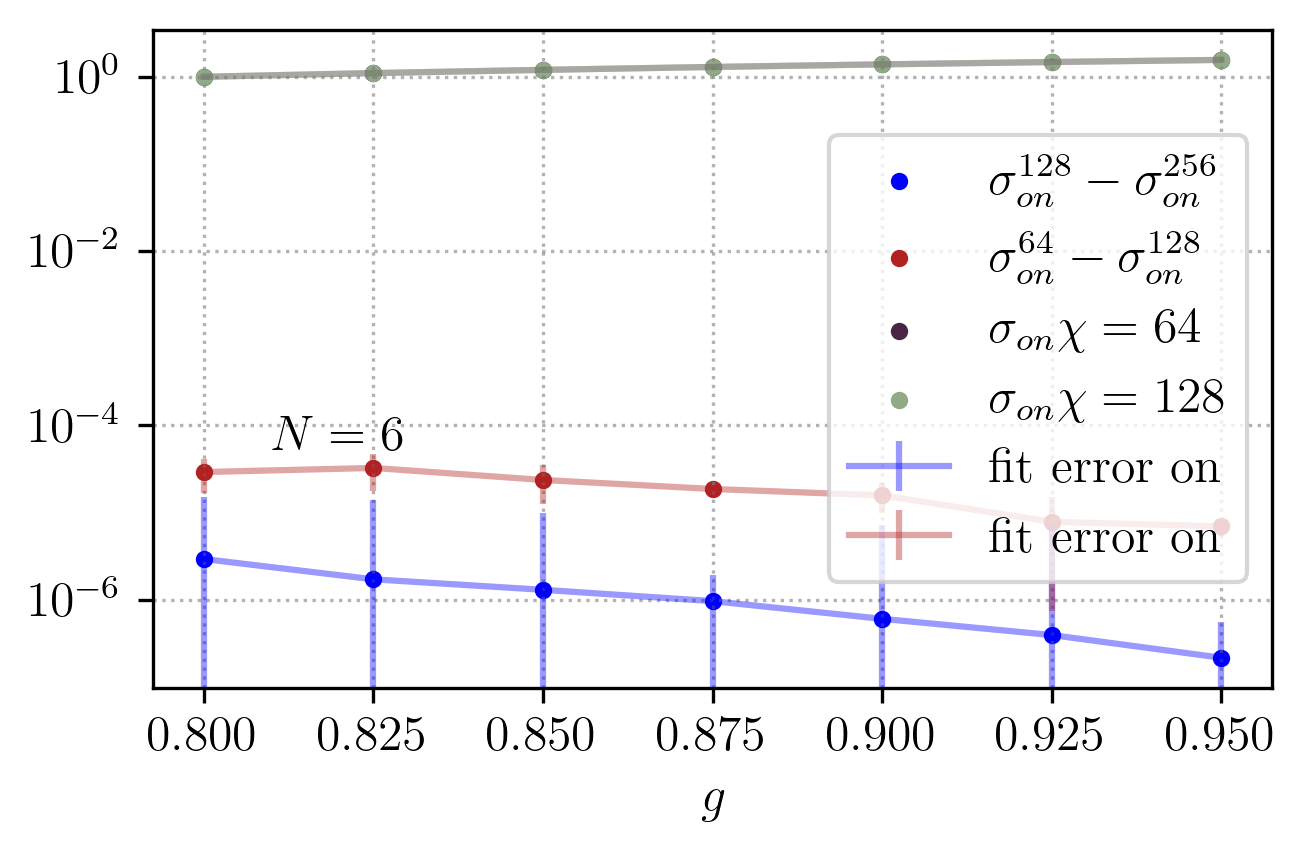

In [ ]:
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
Rs = [12,13,14,15,16,17,19]

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# Rs = [12,13,14,15,16,17,19]

chis = [64, 128]
chis = [128, 256]
fit = 1

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

diff_tot = []
err_tot = []
for g in gs:
    potentials_on = []
    for R in Rs:
        potential_on = static_potential_chis(
                g, R, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy
            )
        potentials_on.append(potential_on)

    potentials_on = np.asarray(potentials_on).T
    
    sigma_chis = []
    sigma_chis_err = []
    for i, chi in enumerate(chis):
        popt, errs = fitting(Rs, potentials_on[i], errors=None, fit=fit, guess=None)
        term = popt[0]
        term_err = errs[0]
        sigma_chis.append(term)
        sigma_chis_err.append(term_err)
    # plt.scatter(x=g, y=sigma_chis[0],s=10, color='red', linestyle='--')
    # plt.scatter(x=g, y=sigma_chis[1], s=10, color='blue',linestyle='-')
    diff = np.abs(sigma_chis[0]-sigma_chis[1])
    # diff = sigma_chis[0]-sigma_chis[1]
    diff_err = sigma_chis_err[0] + sigma_chis_err[1]
    diff_tot.append(diff)
    err_tot.append(diff_err)

# ax.scatter(x=gs, y=diff_tot, s=10, color='blue', label=f"$|\\sigma_{{on}}^{{{chis[0]}}}-\\sigma_{{on}}^{{{chis[1]}}}|$")
ax.scatter(x=gs[8:], y=diff_tot[8:], s=10, color='blue', label=f"$\\sigma_{{on}}^{{{chis[0]}}}-\\sigma_{{on}}^{{{chis[1]}}}$")
ax.errorbar(x=gs[8:], y=diff_tot[8:], yerr=err_tot[8:], color='blue', alpha=0.4, label="fit error on")
ax.set_yscale('log')
ax.set_xlabel(r"$g$")


chis = [64,128]
color = "firebrick"
diff_tot = []
err_tot = []
sigmas = []
sigmas_err = []
for g in gs:
    potentials_on = []
    for R in Rs:
        potential_on = static_potential_chis(
                g, R, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy
            )
        potentials_on.append(potential_on)

    potentials_on = np.asarray(potentials_on).T
    
    sigma_chis = []
    sigma_chis_err = []
    for i, chi in enumerate(chis):
        popt, errs = fitting(Rs, potentials_on[i], errors=None, fit=fit, guess=None)
        term = popt[0]
        term_err = errs[0]
        sigma_chis.append(term)
        sigma_chis_err.append(term_err)
    # plt.scatter(x=g, y=sigma_chis[0],s=10, color='red', linestyle='--')
    # plt.scatter(x=g, y=sigma_chis[1], s=10, color='blue',linestyle='-')
    diff = np.abs(sigma_chis[0]-sigma_chis[1])
    # diff = sigma_chis[0]-sigma_chis[1]
    diff_err = sigma_chis_err[0] + sigma_chis_err[1]
    diff_tot.append(diff)
    err_tot.append(diff_err)
    sigmas.append(sigma_chis)
    sigmas_err.append(sigma_chis_err)


# ax.scatter(x=gs, y=diff_tot, s=10, color='blue', label=f"$|\\sigma_{{on}}^{{{chis[0]}}}-\\sigma_{{on}}^{{{chis[1]}}}|$")
ax.scatter(x=gs[8:], y=diff_tot[8:], s=10, color=color, label=f"$\\sigma_{{on}}^{{{chis[0]}}}-\\sigma_{{on}}^{{{chis[1]}}}$")
ax.errorbar(x=gs[8:], y=diff_tot[8:], yerr=err_tot[8:], color=color, alpha=0.4, label="fit error on")

colors = ["#4a2545","#90AA86"]
sigmas = np.asarray(sigmas).T
sigmas_err = np.asarray(sigmas_err).T

ax.scatter(x=gs[8:], y=sigmas[0][8:], s=10, color=colors[0], label=f"$\\sigma_{{on}} \\chi={chis[0]}$")
ax.scatter(x=gs[8:], y=sigmas[1][8:], s=10, color=colors[1], label=f"$\\sigma_{{on}} \\chi={chis[1]}$")
ax.errorbar(x=gs[8:], y=sigmas[0][8:], yerr=sigmas_err[0][8:], color=colors[0], alpha=0.4)
ax.errorbar(x=gs[8:], y=sigmas[1][8:], yerr=sigmas_err[1][8:], color=colors[1], alpha=0.4)

ax.set_yscale('log')


# ax.scatter(x=gs[8:], y=diff_tot[8:], s=10, color=color, label=f"$\\sigma_{{off}}^{{{chis[0]}}}-\\sigma_{{off}}^{{{chis[1]}}}$")
# ax.errorbar(x=gs[8:], y=diff_tot[8:], yerr=err_tot[8:], color=color, alpha=0.4, label="fit error off")
# ax.set_yscale('log')
# sigmas_on, sigmas_on_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=0, cy=None)
# sigmas_off, sigmas_off_err = get_fit_params(gs,Rs,l,Ls,chis,bc,sector,h_i,h_f,npoints,path, fit=fit, param=0, cy=[0,1])
# obs = np.abs(np.asarray(sigmas_on) - np.asarray(sigmas_off))
# obs = np.asarray(sigmas_off) - np.asarray(sigmas_on)
# obs_err = np.asarray(sigmas_on_err) + np.asarray(sigmas_off_err)
# # ax.plot(gs, obs, marker='p', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$|\\sigma_{{off}}^{{{chis[-1]}}} - \\sigma_{{on}}^{{{chis[-1]}}}|$")
# ax.plot(gs, obs, marker='p', markersize=5, color=color, linestyle="-", linewidth=1, label=f"$\\sigma_{{off}}^{{{chis[-1]}}} - \\sigma_{{on}}^{{{chis[-1]}}}$")

ax.text(0.81, 5e-5, f"$N = {l}$")
# ax.set_ylim(top=1e-4)
ax.legend()

fig.tight_layout()
# fig.savefig(f"{path_figures}/figures/fluxtube/difference_sigma_on-on_bond_dim_{chis}_{l}x{L}_Rs_{Rs}_log_limited.pdf", bbox_inches="tight")

In [249]:
def string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param: int=0, fit: int=1, euclidean: bool=False, manhatten: bool=False, ris: bool=False):
    if euclidean:
        cy = [0,1]

    ## method 1
    list_Rs = []
    Rs  = Rss.copy()
    for R in Rs:
        print(Rss)
        list_Rs.append(Rss.copy())
        if len(Rss) > 4+fit:
            Rss.pop(0)
        else:
            break

    ## method 2
    # list_Rs = [Rss.copy()]
    # for i in range(3):
    #     list_Rs.append(list_Rs[i]+[list_Rs[i][-1]+1])
    #     print(list_Rs)

    sigmas_tot = []
    sigmas_tot_err = []
    sigmas_ri = np.zeros((len(list_Rs), len(gs)))
    for j, g in enumerate(gs):
        sigma_g_ri_chi = []
        sigma_g_ri_chi_err = []
        for i, Rs in enumerate(list_Rs):        
            potentials = []
            for R in Rs:
                pots = static_potential_chis(
                        g, R, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy
                    )
                potentials.append(pots)

            potentials = np.asarray(potentials).T
            
            if euclidean:
                Rs = [np.sqrt(R**2+1) for R in Rs]
            if manhatten:
                Rs = [R+1 for R in Rs]

            sigma_chis = []
            sigma_chis_err = []
            for k, chi in enumerate(chis):
                popt, errs = fitting(Rs, potentials[k], errors=None, fit=fit, guess=None)
                term = popt[param]
                term_err = errs[param]
                sigma_chis.append(term)
                sigma_chis_err.append(term_err)
            sigma_g_ri_chi_err.append(np.abs(sigma_chis[0]-sigma_chis[1]) + sigma_chis_err[0] + sigma_chis_err[1])
            sigma_g_ri_chi.append(sigma_chis[-1])
            sigmas_ri[i,j] = sigma_chis[-1]
        av, av_err = weighted_average(sigma_g_ri_chi, sigma_g_ri_chi_err)
        sigmas_tot.append(av)
        sigmas_tot_err.append(av_err)
    if ris:
        return sigmas_tot, sigmas_tot_err, sigmas_ri, list_Rs
    else:
        return sigmas_tot, sigmas_tot_err

[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
[14, 15, 16, 17, 19]
heeerreeee:  0.08814027611176499
heeerreeee:  0.08953895137301279
heeerreeee:  0.09079084566966171
Weighted Average: 0.08935090268593737
Error in the Average: 0.0009945985565779415
heeerreeee:  0.1948593131169901
heeerreeee:  0.1950441387515477
heeerreeee:  0.1952910981314728
Weighted Average: 0.19501887440657936
Error in the Average: 0.00025976213255634467
heeerreeee:  0.32078056254589976
heeerreeee:  0.3208157412803772
heeerreeee:  0.3208666951262802
Weighted Average: 0.3208170975820445
Error in the Average: 0.00012146752659660849
heeerreeee:  0.441280278610021
heeerreeee:  0.4412968933968296
heeerreeee:  0.44131760670333825
Weighted Average: 0.441297086778539
Error in the Average: 8.685484862484056e-05
heeerreeee:  0.5581672943433778
heeerreeee:  0.5581753676206622
heeerreeee:  0.5581830995858976
Weighted Average: 0.5581747520786206
Error in the Average: 4.654435831671956e-05
heeerreeee:  0.6721375676787766
h

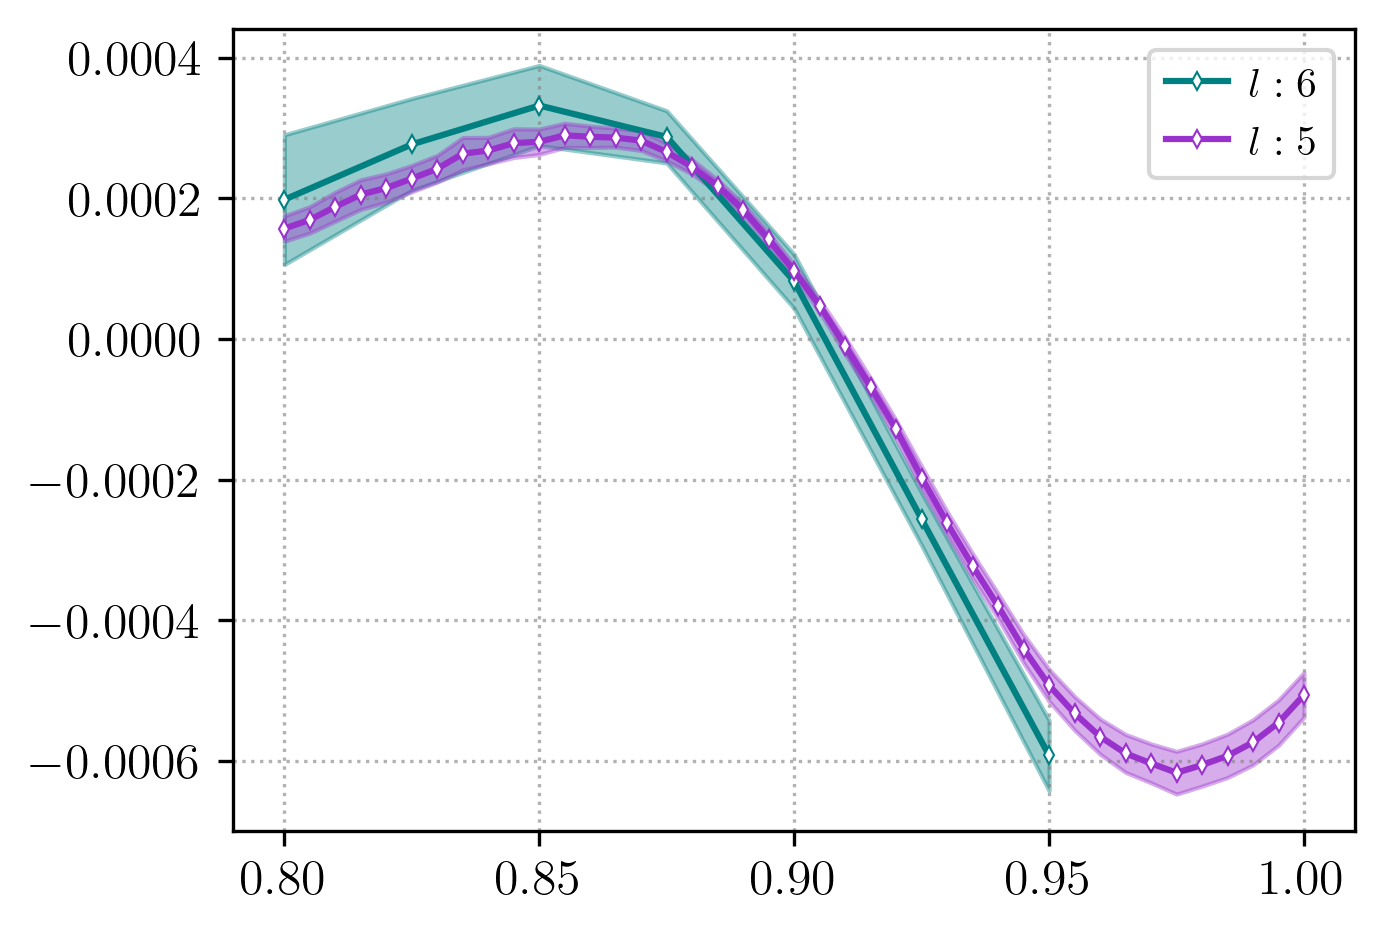

In [232]:
param = 0
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
chis = [64,128]
Rss = [12,13,14,15,16,17,19]
# Rss = [12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]

sigmas_on, sigmas_on_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
Rss = [12,13,14,15,16,17,19]
# Rss = [12,13,14,15,16,17,19]
sigmas_off, sigmas_off_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[8:], obs[8:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$l: {l}$")
# ax.plot(gs[8:], obs[8:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[8:], y1=obs[8:]-obs_err[8:], y2=obs[8:]+obs_err[8:], color="teal", alpha=0.4)
ax.legend()

# l = 5
# h_i, h_f, npoints = 1.0, 2.0, 11
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]

l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rss = [12,13,14,15,16,17,18,19,20]

sigmas_on, sigmas_on_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
Rss = [12,13,14,15,16,17,18,19,20]
sigmas_off, sigmas_off_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

ax.plot(gs[0:], obs[0:], markersize=3, color="darkorchid", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$l: {l}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="darkorchid", alpha=0.4)
ax.legend()

[12, 13, 14, 15, 16, 17, 18, 19, 20]
[13, 14, 15, 16, 17, 18, 19, 20]
[14, 15, 16, 17, 18, 19, 20]
[15, 16, 17, 18, 19, 20]
[16, 17, 18, 19, 20]
heeerreeee:  0.995465608422752
heeerreeee:  0.9954759088334895
heeerreeee:  0.9954844832740667
heeerreeee:  0.9954917085110664
heeerreeee:  0.9954978650553116
Weighted Average: 0.9954821436228817
Error in the Average: 9.170610972672029e-06
heeerreeee:  1.0160167741285897
heeerreeee:  1.0160273349509925
heeerreeee:  1.0160361752921516
heeerreeee:  1.0160436524940772
heeerreeee:  1.016050046286925
Weighted Average: 1.016035606705064
Error in the Average: 8.76747435376314e-06
heeerreeee:  1.0364365044854276
heeerreeee:  1.0364472498142416
heeerreeee:  1.036456298541531
heeerreeee:  1.0364639900473616
heeerreeee:  1.0364705775956482
Weighted Average: 1.0364566420982915
Error in the Average: 8.79355386025168e-06
heeerreeee:  1.056725133378955
heeerreeee:  1.0567359728670773
heeerreeee:  1.0567451633888132
heeerreeee:  1.0567530141733434
heeerreeee:

/Users/fradm/Desktop/qs-mps/src/qs_mps/applications/Z2/relevant_observables.py:488: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(potential_fit_1, Rs, potentials, sigma=errors, p0=guess)


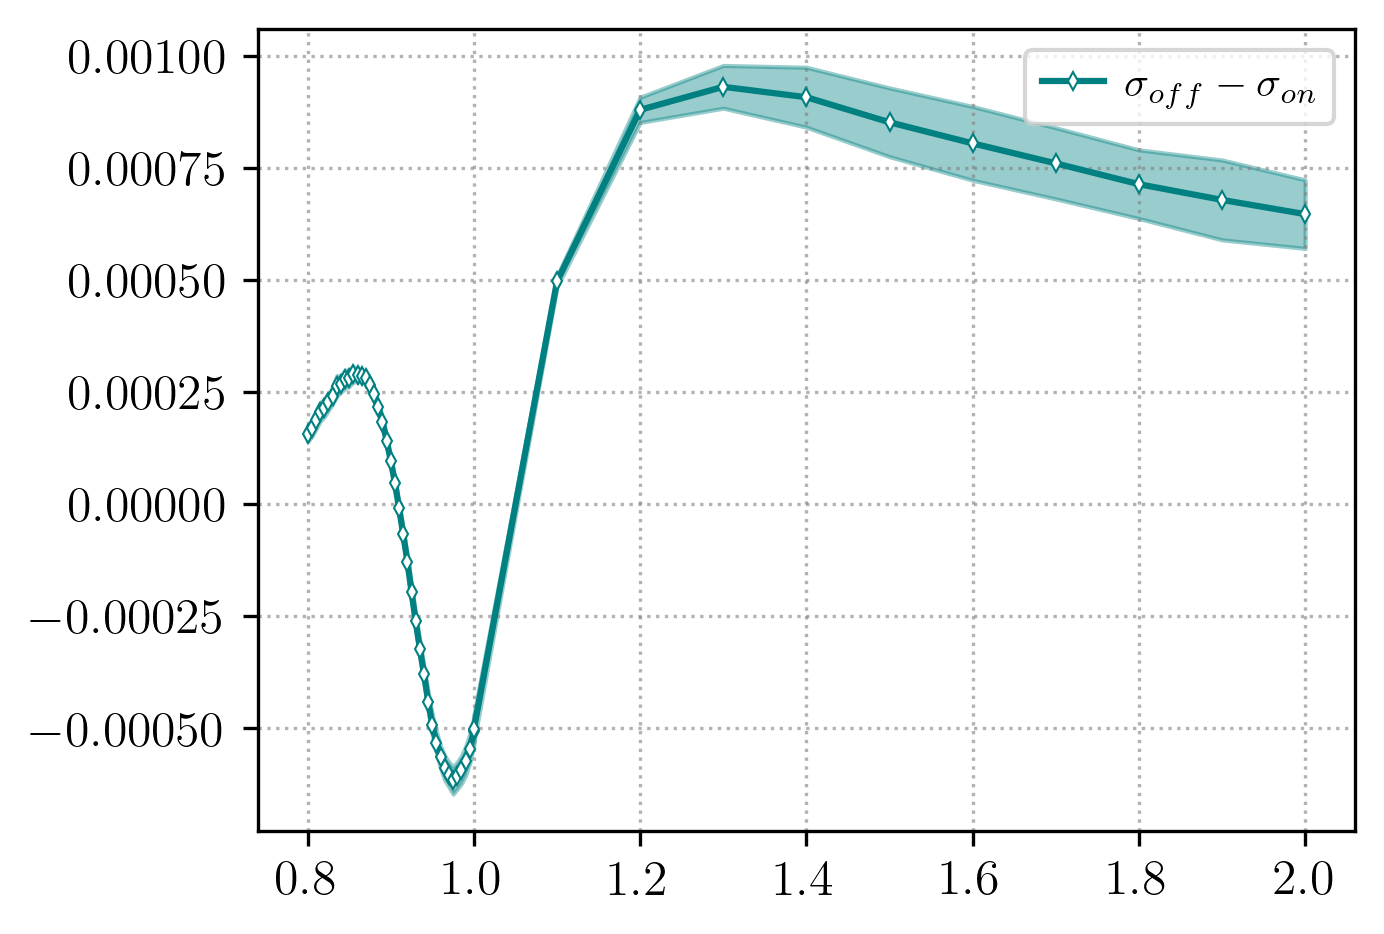

In [233]:
fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

l = 5
h_i, h_f, npoints = 0.8, 1.0, 41
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]
Rss = [12,13,14,15,16,17,18,19,20]

sigmas_on, sigmas_on_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
Rss = [12,13,14,15,16,17,18,19,20]
sigmas_off, sigmas_off_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)


ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)

l = 5
h_i, h_f, npoints = 1.0, 2.0, 11
gs = np.linspace(h_i,h_f,npoints)
chis = [64,128]
Rss = [12,13,14,15,16,17,18,19,20]

sigmas_on, sigmas_on_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit)
Rss = [12,13,14,15,16,17,18,19,20]
sigmas_off, sigmas_off_err = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w')
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)

ax.legend()

[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
[14, 15, 16, 17, 19]
heeerreeee:  0.08591689576043113
heeerreeee:  0.08814027611176499
heeerreeee:  0.08953895137301279
heeerreeee:  0.09079084566966171
Weighted Average: 0.08829862969684736
Error in the Average: 0.0008283118293473222
heeerreeee:  0.19473266214403245
heeerreeee:  0.1948593131169901
heeerreeee:  0.1950441387515477
heeerreeee:  0.1952910981314728
Weighted Average: 0.19487056810333242
Error in the Average: 0.0001803114224364597
heeerreeee:  0.3207570782385822
heeerreeee:  0.32078056254589976
heeerreeee:  0.3208157412803772
heeerreeee:  0.3208666951262802
Weighted Average: 0.32079378055014784
Error in the Average: 9.498636688745266e-05
heeerreeee:  0.44125547797519715
heeerreeee:  0.441280278610021
heeerreeee:  0.4412968933968296
heeerreeee:  0.44131760670333825
Weighted Average: 0.441282817518413
Error in the Average: 7.040395909117076e-05
heeerreeee:  0.5581504647291735
heeerreeee:  0.

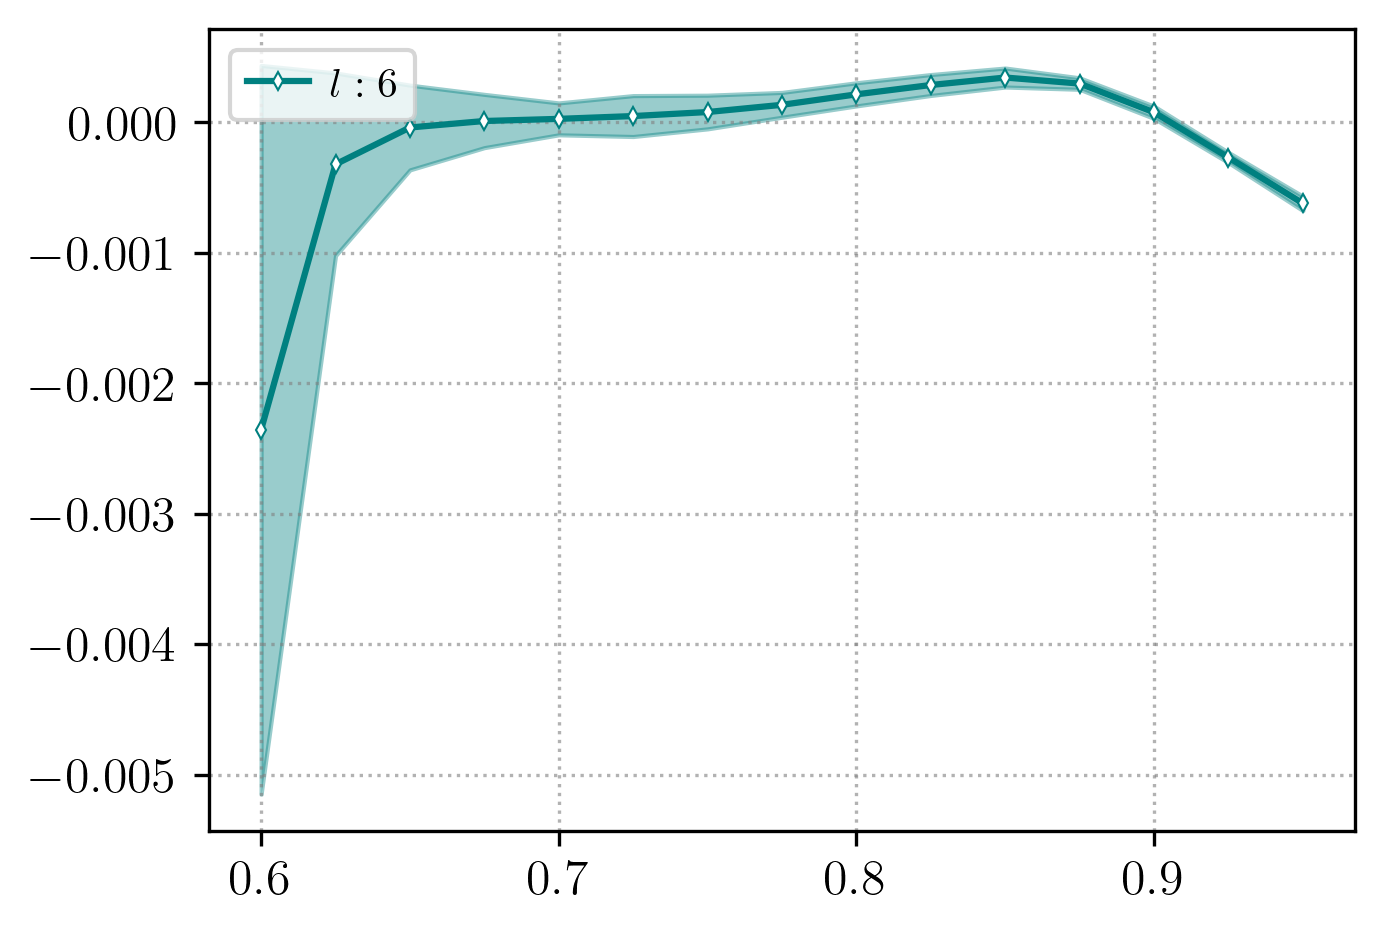

In [234]:
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [13,14,15,16,17,18,19,20]

sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [10,12,13,14,15,16,17,19]
# Rss = [13,14,15,16,17,18,19,20]
# Rss = [12,13,14,15,16,17,19]
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.grid(color="gray", linestyle=":", alpha=0.6)

ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$l: {l}$")
# ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
ax.legend()

# colors = create_sequential_colors(len(list_Rs))
# i = 0
# for sigma_on_ri, sigma_off_ri, Rs in zip(sigmas_on_ris, sigmas_off_ris, list_Rs):
#     obs = np.array(sigma_off_ri) - np.array(sigma_on_ri)
#     ax.plot(gs[0:], obs[0:], markersize=3, color=colors[i], marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$list: {Rs}$")
#     i += 1

# l = 5
# h_i, h_f, npoints = 1.0, 2.0, 11
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [12,13,14,15,16,17,18,19,20]

# sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
# Rss = [12,13,14,15,16,17,18,19,20]
# # Rss = [12,13,14,15,16,17,18,19,20,19]
# sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

# obs = np.array(sigmas_off) - np.array(sigmas_on)
# obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

# # ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w')
# # # ax.plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
# # ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)

# colors = create_sequential_colors(len(list_Rs))
# i = 0
# for sigma_on_ri, sigma_off_ri, Rs in zip(sigmas_on_ris, sigmas_off_ris, list_Rs):
#     obs = np.array(sigma_off_ri) - np.array(sigma_on_ri)
#     print(obs)
#     ax.plot(gs[0:], obs[0:], markersize=3, color=colors[i], marker='d', fillstyle=None, mew=0.5, mfc='w')
#     i += 1
ax.legend()

[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
[14, 15, 16, 17, 19]
heeerreeee:  0.08591689576043113
heeerreeee:  0.08814027611176499
heeerreeee:  0.08953895137301279
heeerreeee:  0.09079084566966171
Weighted Average: 0.08829862969684736
Error in the Average: 0.0008283118293473222
heeerreeee:  0.19473266214403245
heeerreeee:  0.1948593131169901
heeerreeee:  0.1950441387515477
heeerreeee:  0.1952910981314728
Weighted Average: 0.19487056810333242
Error in the Average: 0.0001803114224364597
heeerreeee:  0.3207570782385822
heeerreeee:  0.32078056254589976
heeerreeee:  0.3208157412803772
heeerreeee:  0.3208666951262802
Weighted Average: 0.32079378055014784
Error in the Average: 9.498636688745266e-05
heeerreeee:  0.44125547797519715
heeerreeee:  0.441280278610021
heeerreeee:  0.4412968933968296
heeerreeee:  0.44131760670333825
Weighted Average: 0.441282817518413
Error in the Average: 7.040395909117076e-05
heeerreeee:  0.5581504647291735
heeerreeee:  0.

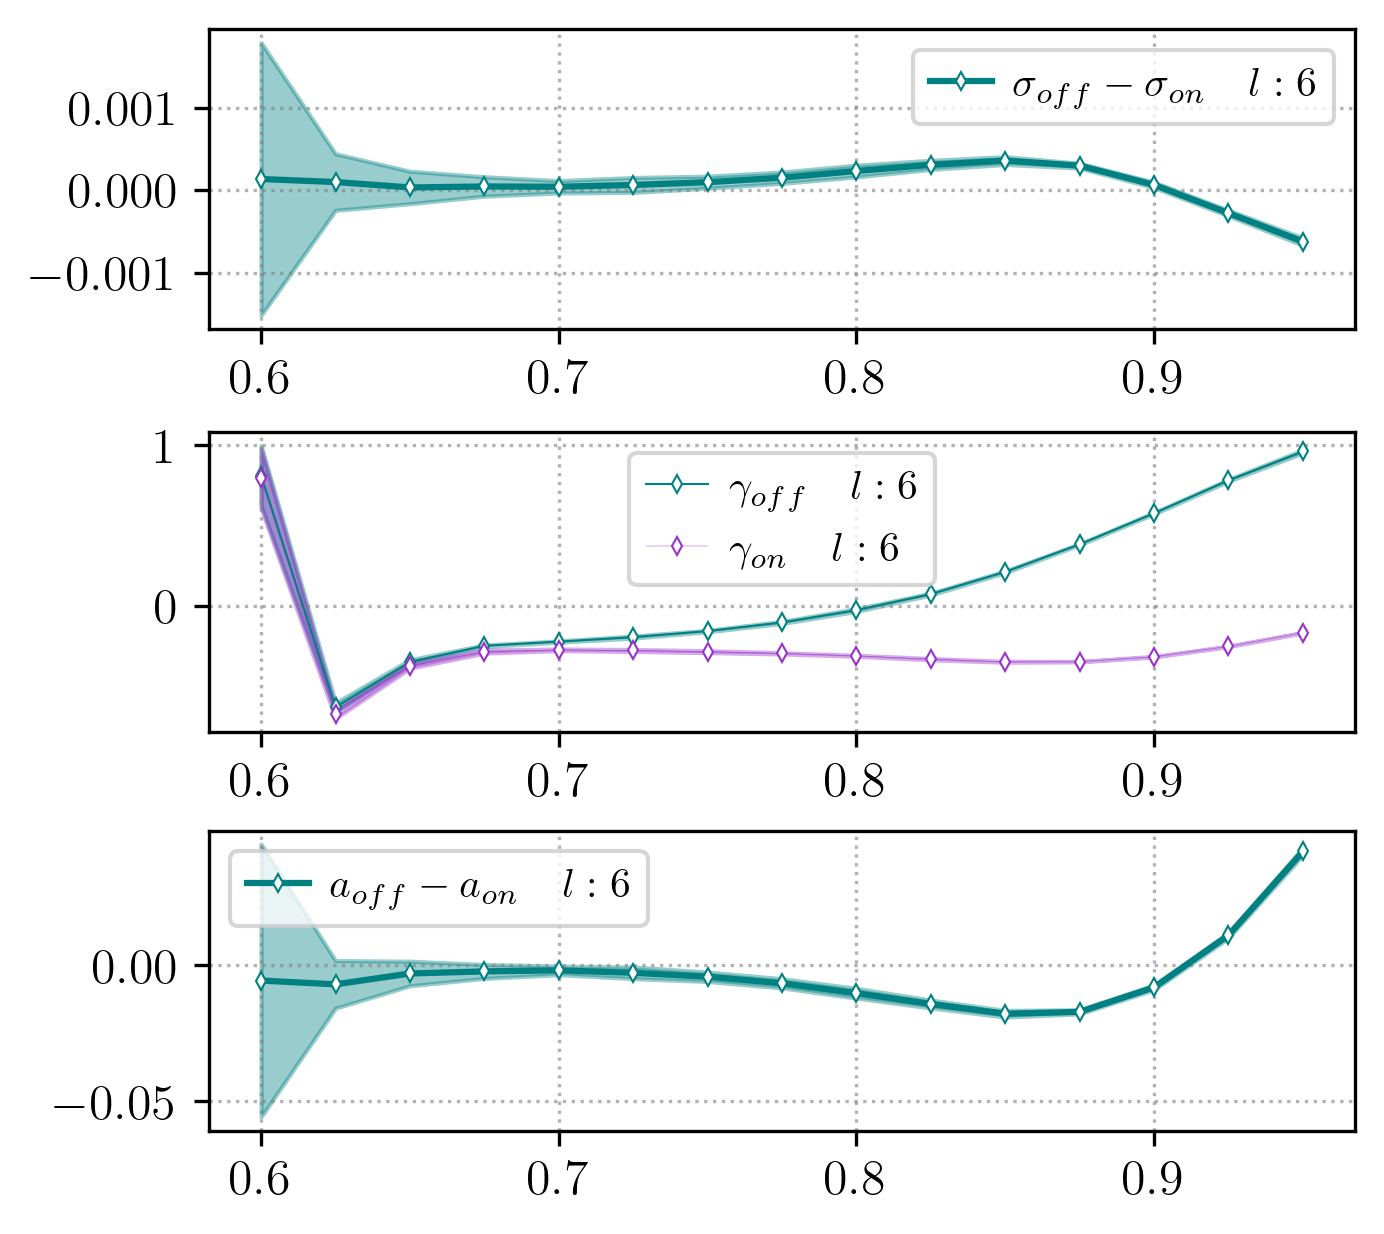

In [ ]:
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [13,14,15,16,17,18,19,20]

param = 0
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [10,12,13,14,15,16,17,19]
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(sigmas_off) - np.array(sigmas_on)
obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

fig, axs = plt.subplots(3,1, figsize=(4.5, 4))
for ax in axs:
    ax.grid(color="gray", linestyle=":", alpha=0.6)

axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}} \\quad l: {l}$")
# axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
axs[0].fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
axs[0].legend()

# param = 1
# Rss = [10,12,13,14,15,16,17,19]
# lusch_on, lusch_on_err, lusch_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
# Rss = [10,12,13,14,15,16,17,19]
# lusch_off, lusch_off_err, lusch_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

# obs = np.array(lusch_off) - np.array(lusch_on)
# obs_err = np.array(lusch_off_err) + np.array(lusch_on_err)

# axs[1].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{off}} - \\gamma_{{on}} \\quad l: {l}$")
# # axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
# axs[1].fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
# axs[1].legend()

param = 1
Rss = [10,12,13,14,15,16,17,19]
sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [10,12,13,14,15,16,17,19]
sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs_off = np.array(sigmas_off)
obs_on = np.array(sigmas_on)
obs_err_off = np.array(sigmas_off_err)
obs_err_on = np.array(sigmas_on_err)

axs[1].plot(gs[0:], -obs_off[0:], markersize=3, color="teal", marker='d', linewidth=0.5, fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{off}} \\quad l: {l}$")
axs[1].fill_between(x=gs[0:], y1=-obs_off[0:]-obs_err_off[0:], y2=-obs_off[0:]+obs_err_off[0:], color="teal", alpha=0.4)
axs[1].plot(gs[0:], -obs_on[0:], markersize=3, color="darkorchid", marker='d', linewidth=0.1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{on}} \\quad l: {l}$")
axs[1].fill_between(x=gs[0:], y1=-obs_on[0:]-obs_err_on[0:], y2=-obs_on[0:]+obs_err_on[0:], color="darkorchid", alpha=0.4)

axs[1].legend()


param = -1
Rss = [10,12,13,14,15,16,17,19]
const_on, const_on_err, const_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
Rss = [10,12,13,14,15,16,17,19]
const_off, const_off_err, const_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

obs = np.array(const_off) - np.array(const_on)
obs_err = np.array(const_off_err) + np.array(const_on_err)

axs[2].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$a_{{off}} - a_{{on}} \\quad l: {l}$")
# axs[0].plot(gs[0:], obs[0:], markersize=3, color="teal", marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
axs[2].fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color="teal", alpha=0.4)
axs[2].legend()

[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
[14, 15, 16, 17, 19]
Weighted Average: 0.08829862969684736
Error in the Average: 0.0008283118293473222
Weighted Average: 0.19487056810333242
Error in the Average: 0.0001803114224364597
Weighted Average: 0.32079378055014784
Error in the Average: 9.498636688745266e-05
Weighted Average: 0.441282817518413
Error in the Average: 7.040395909117076e-05
Weighted Average: 0.5581679824895774
Error in the Average: 3.952904094154474e-05
Weighted Average: 0.6721345097214612
Error in the Average: 4.248520980301801e-05
Weighted Average: 0.7831048993038077
Error in the Average: 3.879005036491841e-05
Weighted Average: 0.8909452680980707
Error in the Average: 2.5555478710554394e-05
Weighted Average: 0.9955737552507801
Error in the Average: 2.0270104234075046e-05
Weighted Average: 1.0969601176020278
Error in the Average: 2.3471362993010185e-05
Weighted Average: 1.195127555676051
Error in the Average: 1.7968932308433655e

(0.79, 0.9674999999999999)

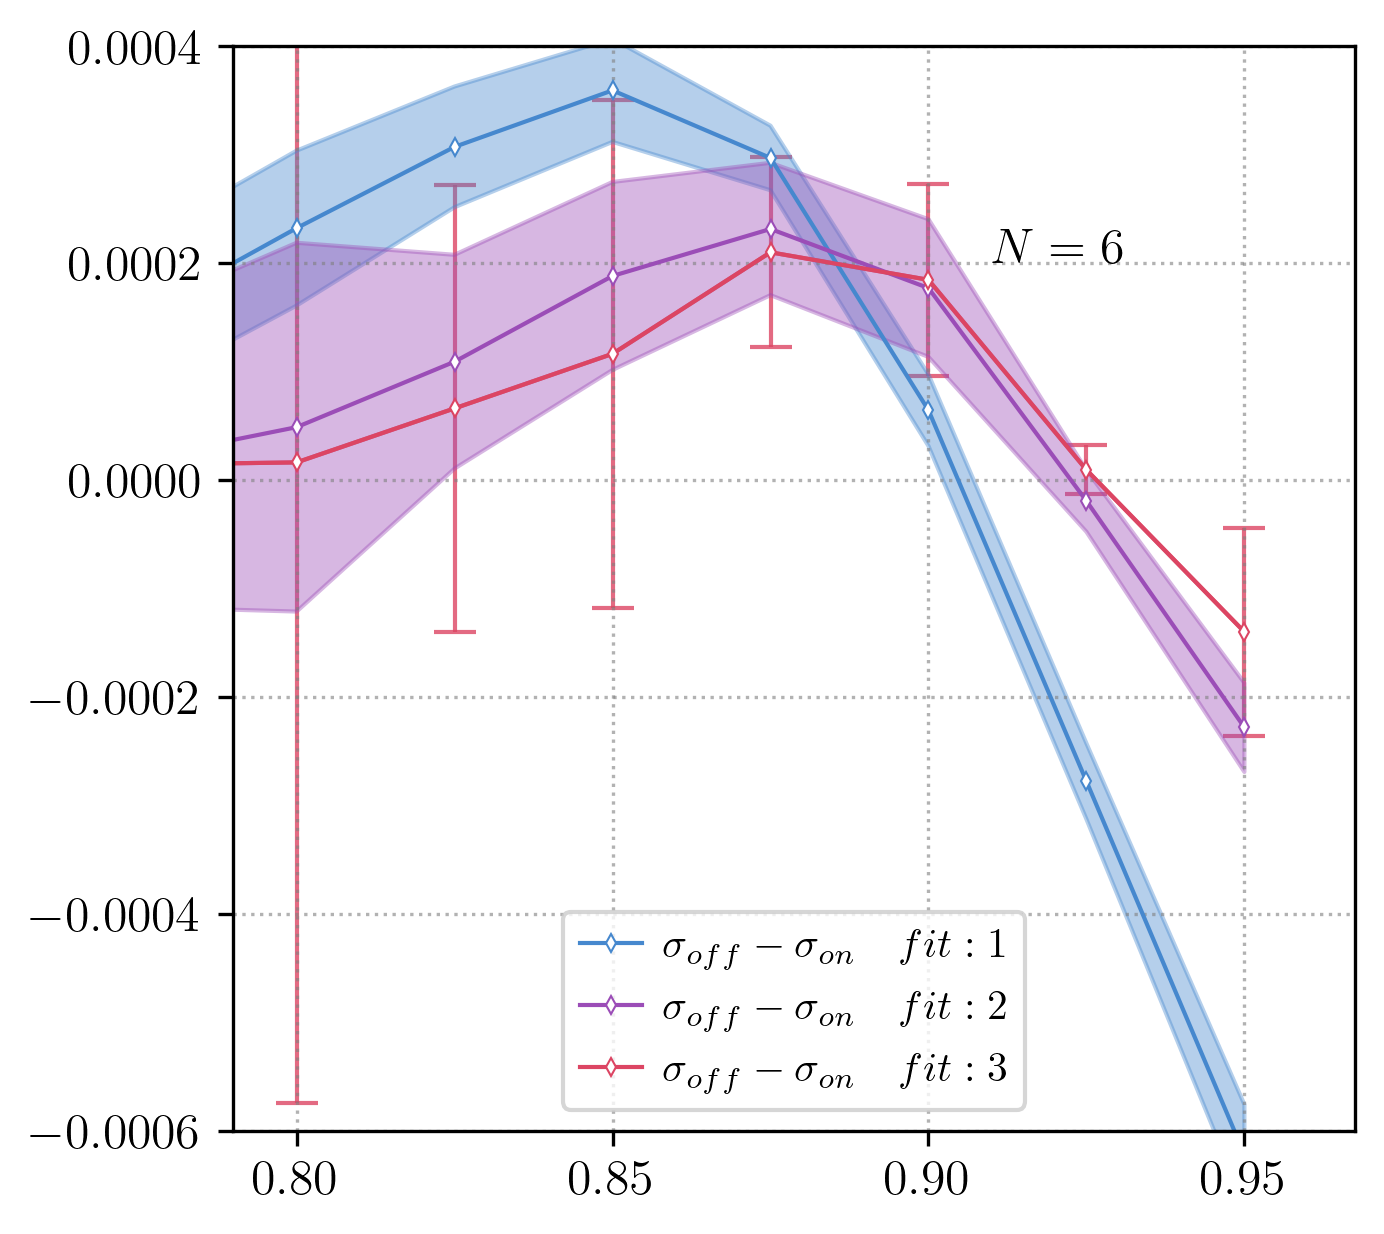

In [278]:
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [10,11,12,13,14,15,16,17,18,19,20]
colors = ["#4688CE","#9B4DB7","#DC4563"]
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.grid(color="gray", linestyle=":", alpha=0.6)

for fit in range(1,4):
    param = 0
    Rss = [10,12,13,14,15,16,17,19]
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
    Rss = [10,12,13,14,15,16,17,19]
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = np.array(sigmas_off) - np.array(sigmas_on)
    obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

    ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}} \\quad fit: {fit}$")
    # ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
    if fit == 1 or fit == 2:
        ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)
    if fit == 3:
        ax.errorbar(x=gs[0:], y=obs[0:], yerr=obs_err[0:], color=colors[fit-1],linewidth=1, capsize=5, alpha=0.8, zorder=0)

# l = 5
# h_i, h_f, npoints = 0.2, 1.0, 21
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [10,11,12,13,14,15,16,17,18,19,20]

# for fit in range(1,4):
#     param = 0
#     # Rss = [10,12,13,14,15,16,17,19]
#     Rss = [10,11,12,13,14,15,16,17,18,19,20]
#     sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
#     # Rss = [10,12,13,14,15,16,17,19]
#     Rss = [10,11,12,13,14,15,16,17,18,19,20]
#     sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

#     obs = np.array(sigmas_off) - np.array(sigmas_on)
#     obs_err = np.array(sigmas_off_err) + np.array(sigmas_on_err)

#     ax.plot(gs[12:16], obs[12:16], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w')
#     # ax.plot(gs[12:16], obs[12:16], markersize=3, color=colors[fit-1], marker='d', fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
#     ax.fill_between(x=gs[12:16], y1=obs[12:16]-obs_err[12:16], y2=obs[12:16]+obs_err[12:16], color=colors[fit-1], alpha=0.4)
#     # ax.errorbar(x=gs[12:16], y=obs[12:16], yerr=obs_err[12:16], color=colors[fit-1], linewidth=1, capsize=5, alpha=0.8, zorder=0)

ax.legend()
ax.text(x=0.91, y=0.0002, s=f"$N={l}$")
ax.set_ylim(-0.0006,0.0004)
ax.set_xlim(left=0.79)

[7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
[8, 9, 10, 12, 13, 14, 15, 16, 17, 19]
[9, 10, 12, 13, 14, 15, 16, 17, 19]
[10, 12, 13, 14, 15, 16, 17, 19]
[12, 13, 14, 15, 16, 17, 19]
[13, 14, 15, 16, 17, 19]
[14, 15, 16, 17, 19]
Weighted Average: -0.16210048412600553
Error in the Average: 0.08715541237320575
Weighted Average: 0.6639256971852573
Error in the Average: 0.010800239978357738
Weighted Average: 0.3746382218612028
Error in the Average: 0.0025118000856797244
Weighted Average: 0.29052131817475846
Error in the Average: 0.0012795375667734984
Weighted Average: 0.27686715554599406
Error in the Average: 0.00108364696944961
Weighted Average: 0.27802377313495075
Error in the Average: 0.001009369439532139
Weighted Average: 0.2853933968475782
Error in the Average: 0.0011504105577572993
Weighted Average: 0.2962113755973905
Error in the Average: 0.001221734122383466
Weighted Average: 0.31288057466724206
Error in the Average: 0.001334803589339815
Weighted Average: 0.3324169903718491
Error in th

(-1.0, 0.0)

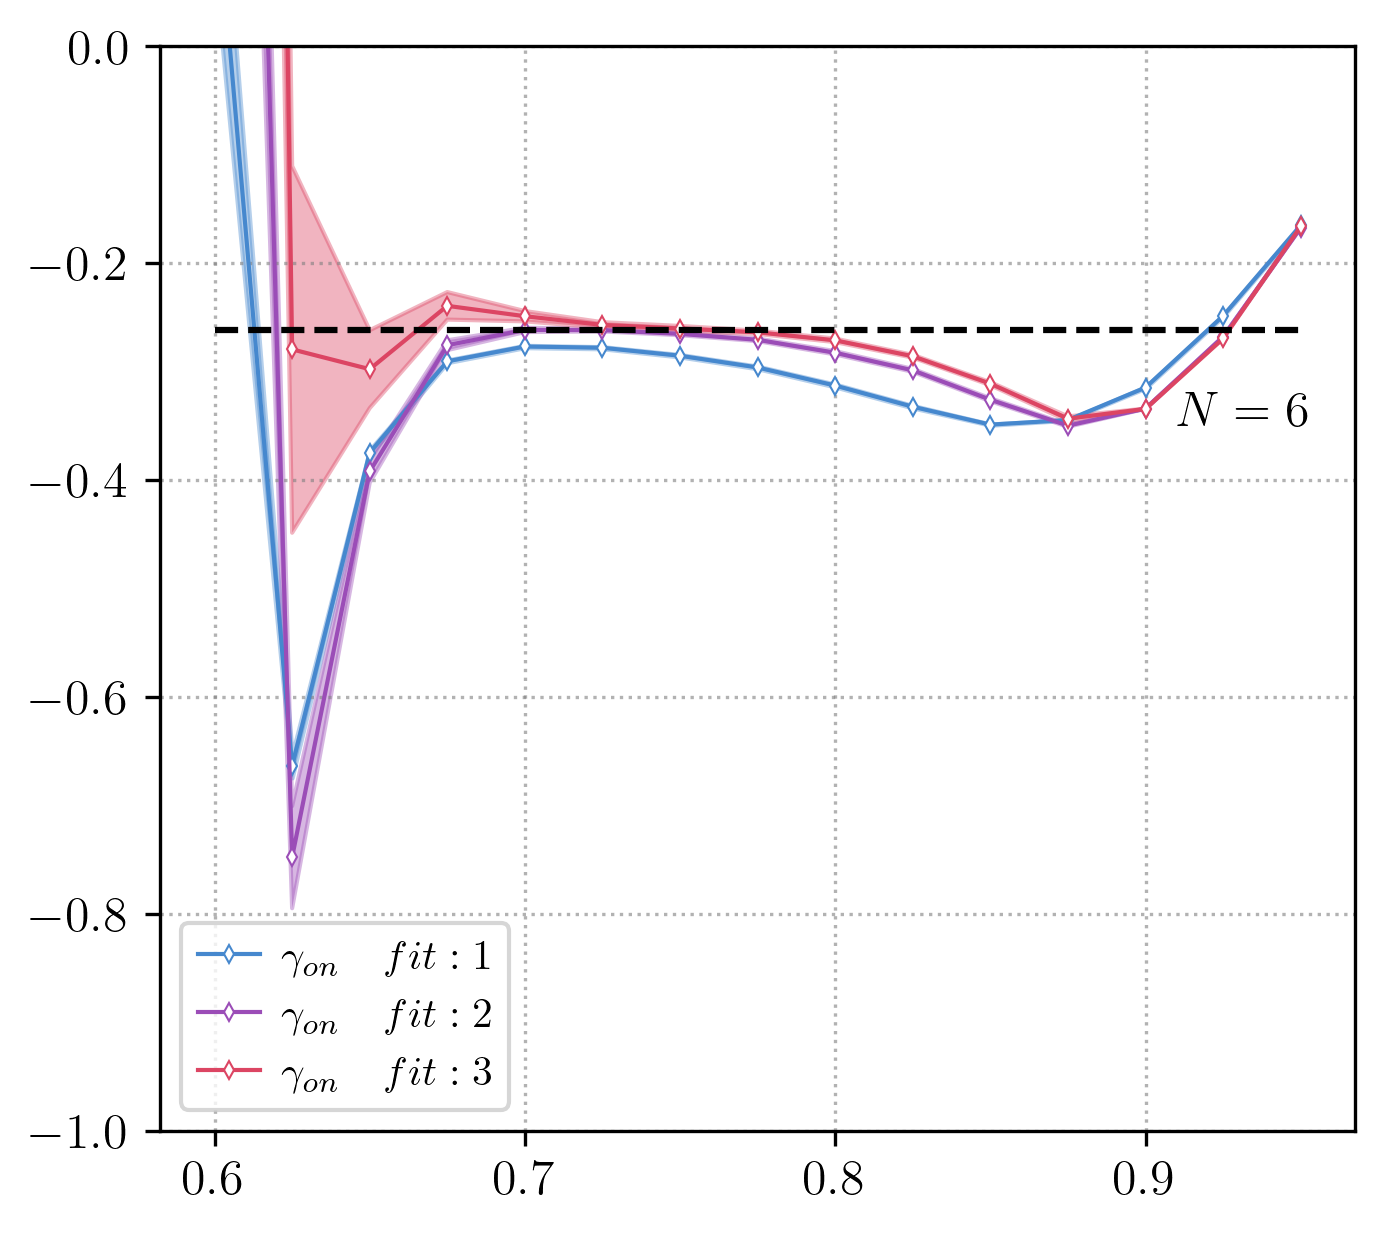

In [295]:
fit = 1
l = 6
h_i, h_f, npoints = 0.6, 0.95, 15
gs = np.linspace(h_i,h_f,npoints)
chis = [128,256]
# chis = [64,128]
Rss = [10,12,13,14,15,16,17,19]
euclidean = True
manhatten = False

# l = 5
# h_i, h_f, npoints = 0.8, 1.0, 41
# gs = np.linspace(h_i,h_f,npoints)
# chis = [64,128]
# Rss = [10,11,12,13,14,15,16,17,18,19,20]
colors = ["#4688CE","#9B4DB7","#DC4563"]
fig, ax = plt.subplots(figsize=(4.5, 4))
ax.grid(color="gray", linestyle=":", alpha=0.6)

for fit in range(1,4):
    param = 1
    Rss = [7,8,9,10,12,13,14,15,16,17,19]
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    sigmas_on, sigmas_on_err, sigmas_on_ris, list_Rs = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, ris=True)
    # Rss = [10,11,12,13,14,15,16,17,18,19,20]
    # sigmas_off, sigmas_off_err, sigmas_off_ris, _ = string_tension_mean(Rss, l, L, chis, bc, sector, h_i, h_f, npoints, path, cx, cy, param, fit, euclidean=euclidean, manhatten=manhatten, ris=True)

    obs = -np.array(sigmas_on)
    obs_err = np.array(sigmas_on_err)

    ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\gamma_{{on}} \\quad fit: {fit}$")
    # ax.plot(gs[0:], obs[0:], markersize=3, color=colors[fit-1], marker='d', linewidth=1, fillstyle=None, mew=0.5, mfc='w', label=f"$\\sigma_{{off}} - \\sigma_{{on}}$")
    if fit == 1 or fit == 2:
        ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)
    if fit == 3:
        # ax.errorbar(x=gs[0:], y=obs[0:], yerr=obs_err[0:], color=colors[fit-1],linewidth=1, capsize=5, alpha=0.8, zorder=0)
        ax.fill_between(x=gs[0:], y1=obs[0:]-obs_err[0:], y2=obs[0:]+obs_err[0:], color=colors[fit-1], alpha=0.4)

ax.hlines(y=-np.pi/12, xmin=gs[0], xmax=gs[-1], color='k', linestyle='--')
ax.legend()
ax.text(x=0.91, y=-0.35, s=f"$N={l}$")
ax.set_ylim(-1,0)